<a href="https://colab.research.google.com/github/stefan-stein/Generate_fashin_with_GANS/blob/master/Create_fashion_using_gans_and_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate new fashion items using a Generative Adversarial Network

In this notebook I use the MNIST dataset and a Generative Adversarial Network (GAN) to generate new fashion items based on those contained in MNIST.

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


To improve performance, I loosely follow this [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks) guide. As a first tip from that guide, I normalize my inputs.

In [0]:
# Normalize data to lie in [-1,1]
x_train = x_train/127.5-1

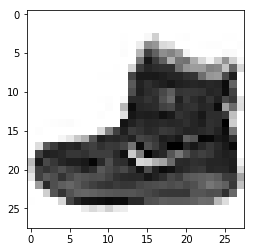

In [4]:
plt.imshow(x_train[0], cmap='Greys')

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

In [0]:
x_train = np.expand_dims(x_train, axis=3)

## Define generator and discriminator
Following the
[How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks) guide, we use the LeakyReLu activation function. That function allows a small positive slope for negative $x$ values given by the parameter $\alpha$, i.e. in the code below, we have $\alpha = 0.2$, which means $\text{WeaklyReLu(x) = 0.2x}$ for $x < 0$.

I use BatchNormalization which normalizes the activations of the previous layer after each batch as advicated in [this paper](https://arxiv.org/abs/1502.03167). This eliminates the need for dropout.

In [7]:
def create_generator():
  model = Sequential()

  model.add(Dense(256, input_dim=100))
  model.add(LeakyReLU(0.2))
  # normalizes activations to be approx. mean 0 and std of activations approx. 1 after each batch
  # when using BatchNormalization, dropout is not needed
  model.add(BatchNormalization(momentum=0.8)) 
  
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
  model.add(Reshape((28, 28, 1)))

  model.summary() # this displays the model summary shown below

  noise = Input(shape=(100,))
  img = model(noise)
  
  # Model() instantiates a model with input=noise and output=img; it includes all layers inbetween
  return Model(noise, img) 

generator = create_generator()
z = Input(shape=(100,))
img = generator(z)





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)         

In [8]:
def create_discriminator():
  model = Sequential()

  model.add(Flatten(input_shape=(28, 28, 1)))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=(28, 28, 1))
  validity = model(img)
  # this means: create_discriminator() returns a model that takes img and returns validity
  return Model(img, validity) 

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

The `combined` model below is what we use to in turn train the descriminator and the generator. It takes a noise variable `z` (np array of length 100), runs it through the `generator` to produce an `img` which is then passed through the `discriminator` which outputs a validitiy score, i.e. how "valid", in the sense of, how likely to be real, the image is. Note that `discriminator` returns a probability.

In [0]:
# combined takes noise z, runs the generator to create img, runs the discriminator and then returns validity
validity = discriminator(img) 
combined = Model(z, validity) 
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

Recall that the generator takes some noise and returns an image. Also, for any model in Keras the `.predict()` method takes an input that fits the model specifications and returns an output as defined by the model architecture. That means, calling `generator.predict(noise)` will generate an image based in the noise.

In [0]:
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise) # the .predict() method is essentially a "run this model with input noise"

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

## Train generator and discriminator

We continue to follow the advise in [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks) and use *label smoothing* in the training process. That is, rather than using the real "hard" labels $1/0$ corresponding to "real" and "fake", we use noisy labels, that is, we sample uniformly at random around $1$ for the real labels and around $0$ for the fake labels. Also, we use "spherical", i.e. Gaussian, noise to feed into the generator, rather than uniform noise. Every 50 epochs we output some sample images. Observe, how they get better over time!

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.056605, acc.: 0.00%] [G loss: 0.688915]


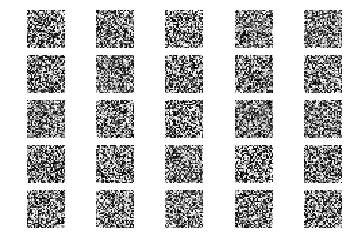

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.622522, acc.: 0.00%] [G loss: 0.670170]
2 [D loss: 0.476560, acc.: 0.00%] [G loss: 0.749123]
3 [D loss: 0.471763, acc.: 0.00%] [G loss: 0.824495]
4 [D loss: 0.446113, acc.: 0.00%] [G loss: 0.867298]
5 [D loss: 0.350291, acc.: 0.00%] [G loss: 0.969790]
6 [D loss: 0.391857, acc.: 0.00%] [G loss: 1.032188]
7 [D loss: 0.403141, acc.: 0.00%] [G loss: 1.062773]
8 [D loss: 0.408982, acc.: 0.00%] [G loss: 1.181984]
9 [D loss: 0.411697, acc.: 0.00%] [G loss: 1.223174]
10 [D loss: 0.393501, acc.: 0.00%] [G loss: 1.277634]
11 [D loss: 0.376287, acc.: 0.00%] [G loss: 1.309550]
12 [D loss: 0.344764, acc.: 0.00%] [G loss: 1.383865]
13 [D loss: 0.307257, acc.: 0.00%] [G loss: 1.419137]
14 [D loss: 0.344878, acc.: 0.00%] [G loss: 1.438728]
15 [D loss: 0.363232, acc.: 0.00%] [G loss: 1.471147]
16 [D loss: 0.352898, acc.: 0.00%] [G loss: 1.458138]
17 [D loss: 0.420113, acc.: 0.00%] [G loss: 1.478411]
18 [D loss: 0.393327, acc.: 0.00%] [G loss: 1.487253]
19 [D loss: 0.371243, acc.: 0.00%] [G

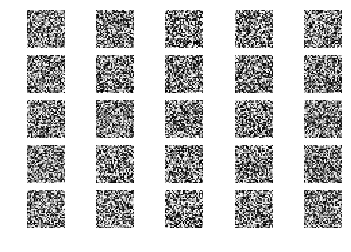

51 [D loss: 0.306914, acc.: 0.00%] [G loss: 1.927138]
52 [D loss: 0.338579, acc.: 0.00%] [G loss: 1.798696]
53 [D loss: 0.280814, acc.: 0.00%] [G loss: 1.760790]
54 [D loss: 0.288270, acc.: 0.00%] [G loss: 1.850241]
55 [D loss: 0.351290, acc.: 0.00%] [G loss: 1.812052]
56 [D loss: 0.394200, acc.: 0.00%] [G loss: 1.917715]
57 [D loss: 0.284269, acc.: 0.00%] [G loss: 1.852891]
58 [D loss: 0.317173, acc.: 0.00%] [G loss: 1.759084]
59 [D loss: 0.269819, acc.: 0.00%] [G loss: 1.835594]
60 [D loss: 0.320681, acc.: 0.00%] [G loss: 1.862742]
61 [D loss: 0.328582, acc.: 0.00%] [G loss: 1.696731]
62 [D loss: 0.312779, acc.: 0.00%] [G loss: 1.876436]
63 [D loss: 0.296218, acc.: 0.00%] [G loss: 1.888047]
64 [D loss: 0.372501, acc.: 0.00%] [G loss: 1.811173]
65 [D loss: 0.349847, acc.: 0.00%] [G loss: 1.817793]
66 [D loss: 0.290145, acc.: 0.00%] [G loss: 1.833439]
67 [D loss: 0.358702, acc.: 0.00%] [G loss: 1.834651]
68 [D loss: 0.418158, acc.: 0.00%] [G loss: 1.759162]
69 [D loss: 0.350063, acc.: 

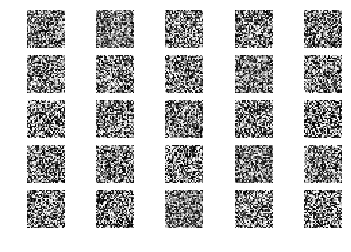

101 [D loss: 0.323038, acc.: 0.00%] [G loss: 1.852342]
102 [D loss: 0.288570, acc.: 0.00%] [G loss: 1.899981]
103 [D loss: 0.292045, acc.: 0.00%] [G loss: 1.814502]
104 [D loss: 0.317891, acc.: 0.00%] [G loss: 1.911721]
105 [D loss: 0.395467, acc.: 0.00%] [G loss: 1.829603]
106 [D loss: 0.342322, acc.: 0.00%] [G loss: 1.944599]
107 [D loss: 0.325539, acc.: 0.00%] [G loss: 1.896692]
108 [D loss: 0.387977, acc.: 0.00%] [G loss: 1.816936]
109 [D loss: 0.383067, acc.: 0.00%] [G loss: 1.749454]
110 [D loss: 0.418187, acc.: 0.00%] [G loss: 1.722480]
111 [D loss: 0.324828, acc.: 0.00%] [G loss: 1.818193]
112 [D loss: 0.238777, acc.: 0.00%] [G loss: 1.678585]
113 [D loss: 0.283177, acc.: 0.00%] [G loss: 1.790451]
114 [D loss: 0.399263, acc.: 0.00%] [G loss: 1.905077]
115 [D loss: 0.332440, acc.: 0.00%] [G loss: 1.869710]
116 [D loss: 0.284321, acc.: 0.00%] [G loss: 1.907384]
117 [D loss: 0.394897, acc.: 0.00%] [G loss: 1.877971]
118 [D loss: 0.338240, acc.: 0.00%] [G loss: 1.821171]
119 [D los

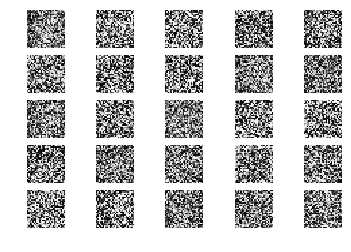

151 [D loss: 0.296655, acc.: 0.00%] [G loss: 1.756866]
152 [D loss: 0.370761, acc.: 0.00%] [G loss: 1.911574]
153 [D loss: 0.351652, acc.: 0.00%] [G loss: 1.920328]
154 [D loss: 0.276391, acc.: 0.00%] [G loss: 1.812559]
155 [D loss: 0.367225, acc.: 0.00%] [G loss: 1.889292]
156 [D loss: 0.306758, acc.: 0.00%] [G loss: 1.851713]
157 [D loss: 0.332340, acc.: 0.00%] [G loss: 1.979009]
158 [D loss: 0.452747, acc.: 0.00%] [G loss: 1.988115]
159 [D loss: 0.375232, acc.: 0.00%] [G loss: 1.888962]
160 [D loss: 0.324076, acc.: 0.00%] [G loss: 1.934285]
161 [D loss: 0.342564, acc.: 0.00%] [G loss: 1.895516]
162 [D loss: 0.351109, acc.: 0.00%] [G loss: 1.835835]
163 [D loss: 0.298508, acc.: 0.00%] [G loss: 1.719875]
164 [D loss: 0.369726, acc.: 0.00%] [G loss: 1.736315]
165 [D loss: 0.345773, acc.: 0.00%] [G loss: 1.841829]
166 [D loss: 0.313486, acc.: 0.00%] [G loss: 1.966090]
167 [D loss: 0.369666, acc.: 0.00%] [G loss: 1.979295]
168 [D loss: 0.398682, acc.: 0.00%] [G loss: 2.012390]
169 [D los

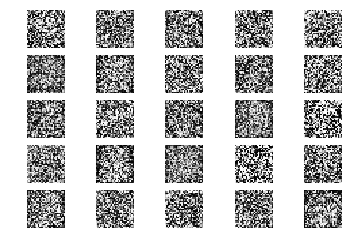

201 [D loss: 0.353544, acc.: 0.00%] [G loss: 1.803276]
202 [D loss: 0.269597, acc.: 0.00%] [G loss: 1.839546]
203 [D loss: 0.378843, acc.: 0.00%] [G loss: 2.005232]
204 [D loss: 0.355019, acc.: 0.00%] [G loss: 1.807809]
205 [D loss: 0.357639, acc.: 0.00%] [G loss: 1.746375]
206 [D loss: 0.364654, acc.: 0.00%] [G loss: 1.834004]
207 [D loss: 0.320268, acc.: 0.00%] [G loss: 1.828623]
208 [D loss: 0.350906, acc.: 0.00%] [G loss: 1.749307]
209 [D loss: 0.285547, acc.: 0.00%] [G loss: 1.832176]
210 [D loss: 0.329690, acc.: 0.00%] [G loss: 1.938668]
211 [D loss: 0.383460, acc.: 0.00%] [G loss: 1.856772]
212 [D loss: 0.324961, acc.: 0.00%] [G loss: 1.793827]
213 [D loss: 0.386537, acc.: 0.00%] [G loss: 1.814369]
214 [D loss: 0.421944, acc.: 0.00%] [G loss: 1.891119]
215 [D loss: 0.338661, acc.: 0.00%] [G loss: 1.805181]
216 [D loss: 0.350977, acc.: 0.00%] [G loss: 1.602463]
217 [D loss: 0.268521, acc.: 0.00%] [G loss: 1.694889]
218 [D loss: 0.435958, acc.: 0.00%] [G loss: 1.875401]
219 [D los

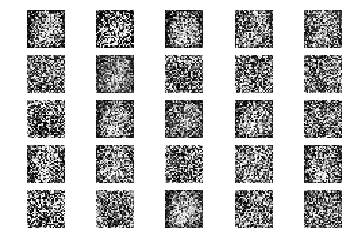

251 [D loss: 0.393582, acc.: 0.00%] [G loss: 1.841875]
252 [D loss: 0.382407, acc.: 0.00%] [G loss: 1.608033]
253 [D loss: 0.320538, acc.: 0.00%] [G loss: 1.738569]
254 [D loss: 0.332017, acc.: 0.00%] [G loss: 1.872940]
255 [D loss: 0.386341, acc.: 0.00%] [G loss: 1.726793]
256 [D loss: 0.335119, acc.: 0.00%] [G loss: 1.710796]
257 [D loss: 0.351178, acc.: 0.00%] [G loss: 1.763656]
258 [D loss: 0.427489, acc.: 0.00%] [G loss: 1.798625]
259 [D loss: 0.403515, acc.: 0.00%] [G loss: 1.555253]
260 [D loss: 0.376684, acc.: 0.00%] [G loss: 1.716238]
261 [D loss: 0.411212, acc.: 0.00%] [G loss: 1.708625]
262 [D loss: 0.432279, acc.: 0.00%] [G loss: 1.888072]
263 [D loss: 0.409232, acc.: 0.00%] [G loss: 1.457077]
264 [D loss: 0.339189, acc.: 0.00%] [G loss: 1.612228]
265 [D loss: 0.368906, acc.: 0.00%] [G loss: 1.618446]
266 [D loss: 0.354970, acc.: 0.00%] [G loss: 1.762822]
267 [D loss: 0.367086, acc.: 0.00%] [G loss: 1.862350]
268 [D loss: 0.389206, acc.: 0.00%] [G loss: 1.849700]
269 [D los

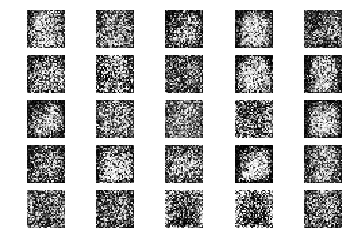

301 [D loss: 0.439650, acc.: 0.00%] [G loss: 1.412793]
302 [D loss: 0.406467, acc.: 0.00%] [G loss: 1.551006]
303 [D loss: 0.386217, acc.: 0.00%] [G loss: 1.692381]
304 [D loss: 0.445624, acc.: 0.00%] [G loss: 1.601254]
305 [D loss: 0.341944, acc.: 0.00%] [G loss: 1.530421]
306 [D loss: 0.408531, acc.: 0.00%] [G loss: 1.815691]
307 [D loss: 0.537642, acc.: 0.00%] [G loss: 1.245070]
308 [D loss: 0.382842, acc.: 0.00%] [G loss: 1.446618]
309 [D loss: 0.377509, acc.: 0.00%] [G loss: 1.652575]
310 [D loss: 0.393876, acc.: 0.00%] [G loss: 1.474269]
311 [D loss: 0.365487, acc.: 0.00%] [G loss: 1.878340]
312 [D loss: 0.391546, acc.: 0.00%] [G loss: 1.691920]
313 [D loss: 0.416850, acc.: 0.00%] [G loss: 1.517303]
314 [D loss: 0.395188, acc.: 0.00%] [G loss: 1.675286]
315 [D loss: 0.382860, acc.: 0.00%] [G loss: 1.710119]
316 [D loss: 0.357837, acc.: 0.00%] [G loss: 1.695745]
317 [D loss: 0.408759, acc.: 0.00%] [G loss: 1.878569]
318 [D loss: 0.438699, acc.: 0.00%] [G loss: 1.624650]
319 [D los

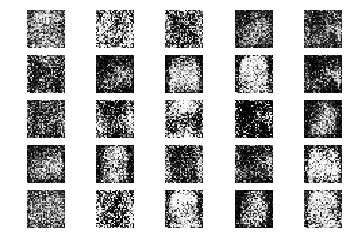

351 [D loss: 0.592931, acc.: 0.00%] [G loss: 1.405142]
352 [D loss: 0.500408, acc.: 0.00%] [G loss: 1.827300]
353 [D loss: 0.557755, acc.: 0.00%] [G loss: 1.275019]
354 [D loss: 0.433817, acc.: 0.00%] [G loss: 1.475978]
355 [D loss: 0.433564, acc.: 0.00%] [G loss: 1.649199]
356 [D loss: 0.556451, acc.: 0.00%] [G loss: 1.624171]
357 [D loss: 0.464279, acc.: 0.00%] [G loss: 1.462936]
358 [D loss: 0.499177, acc.: 0.00%] [G loss: 1.649554]
359 [D loss: 0.606466, acc.: 0.00%] [G loss: 1.306884]
360 [D loss: 0.446897, acc.: 0.00%] [G loss: 1.433551]
361 [D loss: 0.414907, acc.: 0.00%] [G loss: 1.531985]
362 [D loss: 0.485543, acc.: 0.00%] [G loss: 1.657089]
363 [D loss: 0.428160, acc.: 0.00%] [G loss: 1.559824]
364 [D loss: 0.470931, acc.: 0.00%] [G loss: 1.610716]
365 [D loss: 0.467960, acc.: 0.00%] [G loss: 1.484117]
366 [D loss: 0.446085, acc.: 0.00%] [G loss: 1.716184]
367 [D loss: 0.598110, acc.: 0.00%] [G loss: 1.281401]
368 [D loss: 0.527389, acc.: 0.00%] [G loss: 1.377595]
369 [D los

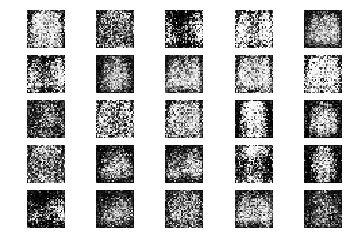

401 [D loss: 0.484517, acc.: 0.00%] [G loss: 1.458122]
402 [D loss: 0.519082, acc.: 0.00%] [G loss: 1.342946]
403 [D loss: 0.482226, acc.: 0.00%] [G loss: 1.583704]
404 [D loss: 0.459633, acc.: 0.00%] [G loss: 1.446804]
405 [D loss: 0.620212, acc.: 0.00%] [G loss: 1.233440]
406 [D loss: 0.421890, acc.: 0.00%] [G loss: 1.538351]
407 [D loss: 0.524504, acc.: 0.00%] [G loss: 1.331423]
408 [D loss: 0.436313, acc.: 0.00%] [G loss: 1.400122]
409 [D loss: 0.459780, acc.: 0.00%] [G loss: 1.594930]
410 [D loss: 0.480806, acc.: 0.00%] [G loss: 1.636633]
411 [D loss: 0.457207, acc.: 0.00%] [G loss: 1.610376]
412 [D loss: 0.541351, acc.: 0.00%] [G loss: 1.226941]
413 [D loss: 0.425595, acc.: 0.00%] [G loss: 1.318749]
414 [D loss: 0.608003, acc.: 0.00%] [G loss: 1.468354]
415 [D loss: 0.494018, acc.: 0.00%] [G loss: 1.559506]
416 [D loss: 0.491119, acc.: 0.00%] [G loss: 1.292169]
417 [D loss: 0.452065, acc.: 0.00%] [G loss: 1.454584]
418 [D loss: 0.587000, acc.: 0.00%] [G loss: 1.434817]
419 [D los

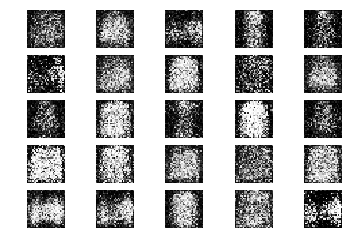

451 [D loss: 0.442136, acc.: 0.00%] [G loss: 1.524828]
452 [D loss: 0.442245, acc.: 0.00%] [G loss: 1.462219]
453 [D loss: 0.646430, acc.: 0.00%] [G loss: 1.293988]
454 [D loss: 0.552824, acc.: 0.00%] [G loss: 1.445732]
455 [D loss: 0.462242, acc.: 0.00%] [G loss: 1.618697]
456 [D loss: 0.649175, acc.: 0.00%] [G loss: 1.292183]
457 [D loss: 0.476871, acc.: 0.00%] [G loss: 1.642598]
458 [D loss: 0.470111, acc.: 0.00%] [G loss: 1.500953]
459 [D loss: 0.469051, acc.: 0.00%] [G loss: 1.615770]
460 [D loss: 0.532256, acc.: 0.00%] [G loss: 1.415517]
461 [D loss: 0.557774, acc.: 0.00%] [G loss: 1.639601]
462 [D loss: 0.451521, acc.: 0.00%] [G loss: 1.666496]
463 [D loss: 0.578673, acc.: 0.00%] [G loss: 1.301713]
464 [D loss: 0.518642, acc.: 0.00%] [G loss: 1.460036]
465 [D loss: 0.528947, acc.: 0.00%] [G loss: 1.520808]
466 [D loss: 0.572869, acc.: 0.00%] [G loss: 1.548340]
467 [D loss: 0.585801, acc.: 0.00%] [G loss: 1.706801]
468 [D loss: 0.545779, acc.: 0.00%] [G loss: 1.363907]
469 [D los

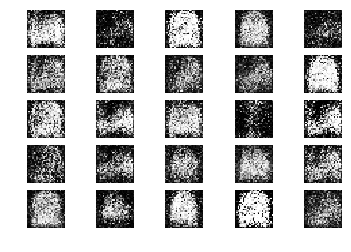

501 [D loss: 0.624846, acc.: 0.00%] [G loss: 1.295490]
502 [D loss: 0.519939, acc.: 0.00%] [G loss: 1.110980]
503 [D loss: 0.599111, acc.: 0.00%] [G loss: 1.248502]
504 [D loss: 0.572448, acc.: 0.00%] [G loss: 1.396137]
505 [D loss: 0.689108, acc.: 0.00%] [G loss: 1.334774]
506 [D loss: 0.595946, acc.: 0.00%] [G loss: 1.130816]
507 [D loss: 0.582213, acc.: 0.00%] [G loss: 1.240297]
508 [D loss: 0.703913, acc.: 0.00%] [G loss: 1.234823]
509 [D loss: 0.636008, acc.: 0.00%] [G loss: 1.260519]
510 [D loss: 0.522032, acc.: 0.00%] [G loss: 1.321167]
511 [D loss: 0.538710, acc.: 0.00%] [G loss: 1.260377]
512 [D loss: 0.578735, acc.: 0.00%] [G loss: 1.220693]
513 [D loss: 0.695099, acc.: 0.00%] [G loss: 1.077312]
514 [D loss: 0.687325, acc.: 0.00%] [G loss: 1.054310]
515 [D loss: 0.566259, acc.: 0.00%] [G loss: 1.091352]
516 [D loss: 0.613046, acc.: 0.00%] [G loss: 1.286279]
517 [D loss: 0.672263, acc.: 0.00%] [G loss: 1.171116]
518 [D loss: 0.586226, acc.: 0.00%] [G loss: 0.961242]
519 [D los

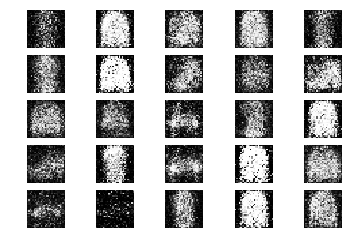

551 [D loss: 0.618365, acc.: 0.00%] [G loss: 1.041190]
552 [D loss: 0.615217, acc.: 0.00%] [G loss: 0.894482]
553 [D loss: 0.631958, acc.: 0.00%] [G loss: 0.912592]
554 [D loss: 0.591188, acc.: 0.00%] [G loss: 1.058131]
555 [D loss: 0.641482, acc.: 0.00%] [G loss: 0.943636]
556 [D loss: 0.759040, acc.: 0.00%] [G loss: 1.040552]
557 [D loss: 0.572071, acc.: 0.00%] [G loss: 0.993976]
558 [D loss: 0.634560, acc.: 0.00%] [G loss: 0.879055]
559 [D loss: 0.649018, acc.: 0.00%] [G loss: 0.921212]
560 [D loss: 0.621021, acc.: 0.00%] [G loss: 0.993431]
561 [D loss: 0.595845, acc.: 0.00%] [G loss: 0.956889]
562 [D loss: 0.607474, acc.: 0.00%] [G loss: 1.004109]
563 [D loss: 0.631561, acc.: 0.00%] [G loss: 0.974647]
564 [D loss: 0.641503, acc.: 0.00%] [G loss: 0.871799]
565 [D loss: 0.594021, acc.: 0.00%] [G loss: 0.937597]
566 [D loss: 0.585878, acc.: 0.00%] [G loss: 0.867908]
567 [D loss: 0.611478, acc.: 0.00%] [G loss: 0.914890]
568 [D loss: 0.587674, acc.: 0.00%] [G loss: 0.990722]
569 [D los

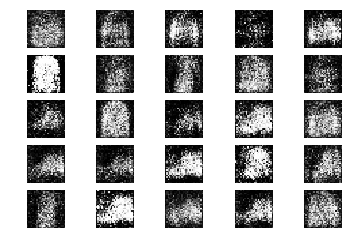

601 [D loss: 0.604437, acc.: 0.00%] [G loss: 0.868793]
602 [D loss: 0.710424, acc.: 0.00%] [G loss: 0.806325]
603 [D loss: 0.629674, acc.: 0.00%] [G loss: 0.951638]
604 [D loss: 0.632266, acc.: 0.00%] [G loss: 0.906274]
605 [D loss: 0.579944, acc.: 0.00%] [G loss: 0.882575]
606 [D loss: 0.611998, acc.: 0.00%] [G loss: 0.941543]
607 [D loss: 0.614129, acc.: 0.00%] [G loss: 0.850772]
608 [D loss: 0.654267, acc.: 0.00%] [G loss: 0.888196]
609 [D loss: 0.691316, acc.: 0.00%] [G loss: 0.791254]
610 [D loss: 0.642862, acc.: 0.00%] [G loss: 0.823653]
611 [D loss: 0.599720, acc.: 0.00%] [G loss: 1.001390]
612 [D loss: 0.628080, acc.: 0.00%] [G loss: 0.892840]
613 [D loss: 0.603556, acc.: 0.00%] [G loss: 0.885816]
614 [D loss: 0.585309, acc.: 0.00%] [G loss: 0.870801]
615 [D loss: 0.606939, acc.: 0.00%] [G loss: 0.935609]
616 [D loss: 0.620718, acc.: 0.00%] [G loss: 0.934156]
617 [D loss: 0.640457, acc.: 0.00%] [G loss: 0.868071]
618 [D loss: 0.640757, acc.: 0.00%] [G loss: 0.769655]
619 [D los

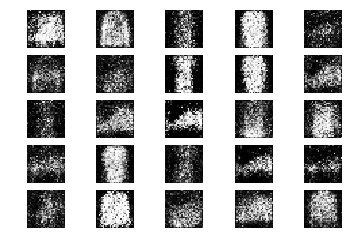

651 [D loss: 0.608832, acc.: 0.00%] [G loss: 0.899912]
652 [D loss: 0.685675, acc.: 0.00%] [G loss: 0.835853]
653 [D loss: 0.586248, acc.: 0.00%] [G loss: 0.916359]
654 [D loss: 0.670624, acc.: 0.00%] [G loss: 0.767715]
655 [D loss: 0.574586, acc.: 0.00%] [G loss: 0.832533]
656 [D loss: 0.634418, acc.: 0.00%] [G loss: 0.826114]
657 [D loss: 0.638236, acc.: 0.00%] [G loss: 0.785949]
658 [D loss: 0.626559, acc.: 0.00%] [G loss: 0.872073]
659 [D loss: 0.638117, acc.: 0.00%] [G loss: 0.886903]
660 [D loss: 0.694673, acc.: 0.00%] [G loss: 0.823601]
661 [D loss: 0.648597, acc.: 0.00%] [G loss: 0.863054]
662 [D loss: 0.677127, acc.: 0.00%] [G loss: 0.788649]
663 [D loss: 0.563309, acc.: 0.00%] [G loss: 0.755315]
664 [D loss: 0.627163, acc.: 0.00%] [G loss: 0.773777]
665 [D loss: 0.628745, acc.: 0.00%] [G loss: 0.856051]
666 [D loss: 0.608706, acc.: 0.00%] [G loss: 0.854221]
667 [D loss: 0.655767, acc.: 0.00%] [G loss: 0.798871]
668 [D loss: 0.647290, acc.: 0.00%] [G loss: 0.874928]
669 [D los

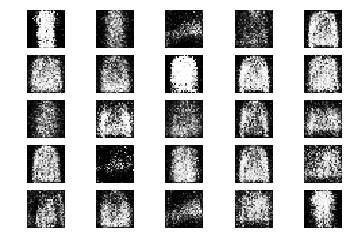

701 [D loss: 0.639926, acc.: 0.00%] [G loss: 0.853793]
702 [D loss: 0.648450, acc.: 0.00%] [G loss: 0.818125]
703 [D loss: 0.607853, acc.: 0.00%] [G loss: 0.781132]
704 [D loss: 0.619614, acc.: 0.00%] [G loss: 0.833157]
705 [D loss: 0.602779, acc.: 0.00%] [G loss: 0.830870]
706 [D loss: 0.632374, acc.: 0.00%] [G loss: 0.847083]
707 [D loss: 0.636263, acc.: 0.00%] [G loss: 0.822100]
708 [D loss: 0.625751, acc.: 0.00%] [G loss: 0.844152]
709 [D loss: 0.581645, acc.: 0.00%] [G loss: 0.873600]
710 [D loss: 0.672599, acc.: 0.00%] [G loss: 0.843774]
711 [D loss: 0.574202, acc.: 0.00%] [G loss: 0.807530]
712 [D loss: 0.643318, acc.: 0.00%] [G loss: 0.739629]
713 [D loss: 0.606849, acc.: 0.00%] [G loss: 0.811155]
714 [D loss: 0.573222, acc.: 0.00%] [G loss: 0.789812]
715 [D loss: 0.656480, acc.: 0.00%] [G loss: 0.815865]
716 [D loss: 0.589499, acc.: 0.00%] [G loss: 0.813909]
717 [D loss: 0.611418, acc.: 0.00%] [G loss: 0.828032]
718 [D loss: 0.639067, acc.: 0.00%] [G loss: 0.763937]
719 [D los

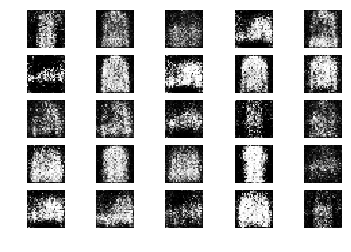

751 [D loss: 0.630081, acc.: 0.00%] [G loss: 0.705281]
752 [D loss: 0.602275, acc.: 0.00%] [G loss: 0.810510]
753 [D loss: 0.612850, acc.: 0.00%] [G loss: 0.815735]
754 [D loss: 0.629235, acc.: 0.00%] [G loss: 0.835443]
755 [D loss: 0.706028, acc.: 0.00%] [G loss: 0.863290]
756 [D loss: 0.637859, acc.: 0.00%] [G loss: 0.814606]
757 [D loss: 0.635534, acc.: 0.00%] [G loss: 0.778794]
758 [D loss: 0.620024, acc.: 0.00%] [G loss: 0.764727]
759 [D loss: 0.586709, acc.: 0.00%] [G loss: 0.743117]
760 [D loss: 0.592466, acc.: 0.00%] [G loss: 0.794778]
761 [D loss: 0.648787, acc.: 0.00%] [G loss: 0.738990]
762 [D loss: 0.649232, acc.: 0.00%] [G loss: 0.844453]
763 [D loss: 0.587549, acc.: 0.00%] [G loss: 0.811549]
764 [D loss: 0.621929, acc.: 0.00%] [G loss: 0.828793]
765 [D loss: 0.595988, acc.: 0.00%] [G loss: 0.877916]
766 [D loss: 0.645931, acc.: 0.00%] [G loss: 0.797745]
767 [D loss: 0.679675, acc.: 0.00%] [G loss: 0.850089]
768 [D loss: 0.646855, acc.: 0.00%] [G loss: 0.754562]
769 [D los

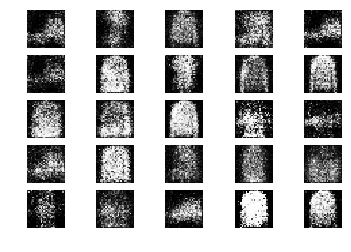

801 [D loss: 0.631150, acc.: 0.00%] [G loss: 0.759989]
802 [D loss: 0.684786, acc.: 0.00%] [G loss: 0.757465]
803 [D loss: 0.630570, acc.: 0.00%] [G loss: 0.796964]
804 [D loss: 0.575868, acc.: 0.00%] [G loss: 0.738473]
805 [D loss: 0.645425, acc.: 0.00%] [G loss: 0.750359]
806 [D loss: 0.633888, acc.: 0.00%] [G loss: 0.740346]
807 [D loss: 0.614876, acc.: 0.00%] [G loss: 0.748938]
808 [D loss: 0.599050, acc.: 0.00%] [G loss: 0.911629]
809 [D loss: 0.632953, acc.: 0.00%] [G loss: 0.811543]
810 [D loss: 0.604210, acc.: 0.00%] [G loss: 0.913712]
811 [D loss: 0.664559, acc.: 0.00%] [G loss: 0.844485]
812 [D loss: 0.589802, acc.: 0.00%] [G loss: 0.832402]
813 [D loss: 0.630386, acc.: 0.00%] [G loss: 0.802223]
814 [D loss: 0.588018, acc.: 0.00%] [G loss: 0.857046]
815 [D loss: 0.616258, acc.: 0.00%] [G loss: 0.725465]
816 [D loss: 0.638717, acc.: 0.00%] [G loss: 0.733693]
817 [D loss: 0.624364, acc.: 0.00%] [G loss: 0.768038]
818 [D loss: 0.606897, acc.: 0.00%] [G loss: 0.759324]
819 [D los

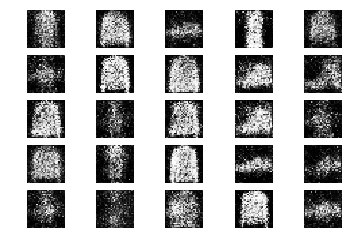

851 [D loss: 0.651057, acc.: 0.00%] [G loss: 0.856036]
852 [D loss: 0.621550, acc.: 0.00%] [G loss: 0.845244]
853 [D loss: 0.657284, acc.: 0.00%] [G loss: 0.863613]
854 [D loss: 0.585881, acc.: 0.00%] [G loss: 0.765384]
855 [D loss: 0.627492, acc.: 0.00%] [G loss: 0.801270]
856 [D loss: 0.615969, acc.: 0.00%] [G loss: 0.768317]
857 [D loss: 0.581032, acc.: 0.00%] [G loss: 0.799000]
858 [D loss: 0.594071, acc.: 0.00%] [G loss: 0.780017]
859 [D loss: 0.625116, acc.: 0.00%] [G loss: 0.761230]
860 [D loss: 0.612837, acc.: 0.00%] [G loss: 0.755314]
861 [D loss: 0.644105, acc.: 0.00%] [G loss: 0.672722]
862 [D loss: 0.576466, acc.: 0.00%] [G loss: 0.783155]
863 [D loss: 0.604107, acc.: 0.00%] [G loss: 0.882649]
864 [D loss: 0.594391, acc.: 0.00%] [G loss: 0.870350]
865 [D loss: 0.650100, acc.: 0.00%] [G loss: 0.830760]
866 [D loss: 0.652259, acc.: 0.00%] [G loss: 0.824337]
867 [D loss: 0.653320, acc.: 0.00%] [G loss: 0.856525]
868 [D loss: 0.597371, acc.: 0.00%] [G loss: 0.805939]
869 [D los

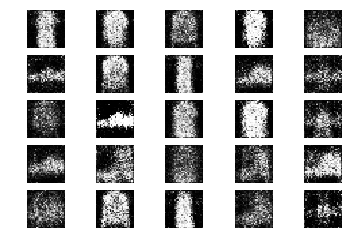

901 [D loss: 0.608624, acc.: 0.00%] [G loss: 0.877447]
902 [D loss: 0.616306, acc.: 0.00%] [G loss: 0.785180]
903 [D loss: 0.602086, acc.: 0.00%] [G loss: 0.897285]
904 [D loss: 0.672382, acc.: 0.00%] [G loss: 0.786447]
905 [D loss: 0.653569, acc.: 0.00%] [G loss: 0.839529]
906 [D loss: 0.656633, acc.: 0.00%] [G loss: 0.740687]
907 [D loss: 0.631209, acc.: 0.00%] [G loss: 0.762064]
908 [D loss: 0.606600, acc.: 0.00%] [G loss: 0.826984]
909 [D loss: 0.665940, acc.: 0.00%] [G loss: 0.751875]
910 [D loss: 0.621568, acc.: 0.00%] [G loss: 0.790860]
911 [D loss: 0.633472, acc.: 0.00%] [G loss: 0.826115]
912 [D loss: 0.624486, acc.: 0.00%] [G loss: 0.841095]
913 [D loss: 0.611349, acc.: 0.00%] [G loss: 0.881896]
914 [D loss: 0.664826, acc.: 0.00%] [G loss: 0.855351]
915 [D loss: 0.652606, acc.: 0.00%] [G loss: 0.866887]
916 [D loss: 0.647607, acc.: 0.00%] [G loss: 0.800496]
917 [D loss: 0.652890, acc.: 0.00%] [G loss: 0.857367]
918 [D loss: 0.664958, acc.: 0.00%] [G loss: 0.809785]
919 [D los

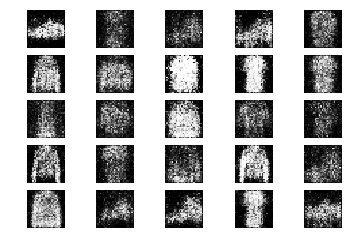

951 [D loss: 0.605444, acc.: 0.00%] [G loss: 0.749494]
952 [D loss: 0.617087, acc.: 0.00%] [G loss: 0.800751]
953 [D loss: 0.642773, acc.: 0.00%] [G loss: 0.766468]
954 [D loss: 0.601793, acc.: 0.00%] [G loss: 0.737387]
955 [D loss: 0.625136, acc.: 0.00%] [G loss: 0.733569]
956 [D loss: 0.647725, acc.: 0.00%] [G loss: 0.832385]
957 [D loss: 0.610819, acc.: 0.00%] [G loss: 0.799270]
958 [D loss: 0.622564, acc.: 0.00%] [G loss: 0.854613]
959 [D loss: 0.693328, acc.: 0.00%] [G loss: 0.774119]
960 [D loss: 0.673685, acc.: 0.00%] [G loss: 0.724971]
961 [D loss: 0.628043, acc.: 0.00%] [G loss: 0.804501]
962 [D loss: 0.707624, acc.: 0.00%] [G loss: 0.722964]
963 [D loss: 0.685993, acc.: 0.00%] [G loss: 0.673618]
964 [D loss: 0.658529, acc.: 0.00%] [G loss: 0.691465]
965 [D loss: 0.668791, acc.: 0.00%] [G loss: 0.752495]
966 [D loss: 0.669929, acc.: 0.00%] [G loss: 0.718881]
967 [D loss: 0.586235, acc.: 0.00%] [G loss: 0.736989]
968 [D loss: 0.623415, acc.: 0.00%] [G loss: 0.785768]
969 [D los

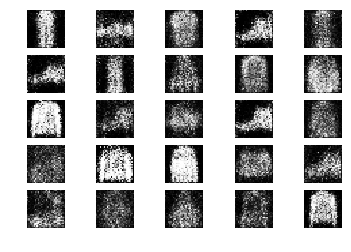

1001 [D loss: 0.656549, acc.: 0.00%] [G loss: 0.776528]
1002 [D loss: 0.592076, acc.: 0.00%] [G loss: 0.764666]
1003 [D loss: 0.673463, acc.: 0.00%] [G loss: 0.796182]
1004 [D loss: 0.626051, acc.: 0.00%] [G loss: 0.756317]
1005 [D loss: 0.648722, acc.: 0.00%] [G loss: 0.710401]
1006 [D loss: 0.695770, acc.: 0.00%] [G loss: 0.764280]
1007 [D loss: 0.681689, acc.: 0.00%] [G loss: 0.718638]
1008 [D loss: 0.607810, acc.: 0.00%] [G loss: 0.789389]
1009 [D loss: 0.665319, acc.: 0.00%] [G loss: 0.760034]
1010 [D loss: 0.632452, acc.: 0.00%] [G loss: 0.835817]
1011 [D loss: 0.682288, acc.: 0.00%] [G loss: 0.760646]
1012 [D loss: 0.669329, acc.: 0.00%] [G loss: 0.760550]
1013 [D loss: 0.653134, acc.: 0.00%] [G loss: 0.724032]
1014 [D loss: 0.667101, acc.: 0.00%] [G loss: 0.725500]
1015 [D loss: 0.645331, acc.: 0.00%] [G loss: 0.739737]
1016 [D loss: 0.671453, acc.: 0.00%] [G loss: 0.740162]
1017 [D loss: 0.631769, acc.: 0.00%] [G loss: 0.759498]
1018 [D loss: 0.665896, acc.: 0.00%] [G loss: 0.

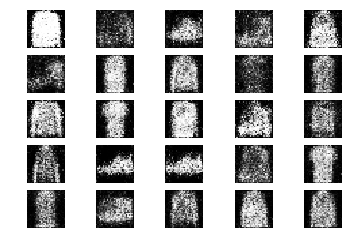

1051 [D loss: 0.660519, acc.: 0.00%] [G loss: 0.755029]
1052 [D loss: 0.650144, acc.: 0.00%] [G loss: 0.749488]
1053 [D loss: 0.611409, acc.: 0.00%] [G loss: 0.734512]
1054 [D loss: 0.652546, acc.: 0.00%] [G loss: 0.822403]
1055 [D loss: 0.702492, acc.: 0.00%] [G loss: 0.730592]
1056 [D loss: 0.644893, acc.: 0.00%] [G loss: 0.769527]
1057 [D loss: 0.649950, acc.: 0.00%] [G loss: 0.757151]
1058 [D loss: 0.695896, acc.: 0.00%] [G loss: 0.726996]
1059 [D loss: 0.615069, acc.: 0.00%] [G loss: 0.752425]
1060 [D loss: 0.663847, acc.: 0.00%] [G loss: 0.754722]
1061 [D loss: 0.661508, acc.: 0.00%] [G loss: 0.728477]
1062 [D loss: 0.696543, acc.: 0.00%] [G loss: 0.747709]
1063 [D loss: 0.701837, acc.: 0.00%] [G loss: 0.711279]
1064 [D loss: 0.627316, acc.: 0.00%] [G loss: 0.756721]
1065 [D loss: 0.666247, acc.: 0.00%] [G loss: 0.784993]
1066 [D loss: 0.626126, acc.: 0.00%] [G loss: 0.758906]
1067 [D loss: 0.647271, acc.: 0.00%] [G loss: 0.745645]
1068 [D loss: 0.633206, acc.: 0.00%] [G loss: 0.

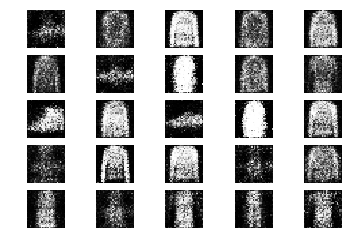

1101 [D loss: 0.654966, acc.: 0.00%] [G loss: 0.745326]
1102 [D loss: 0.589666, acc.: 0.00%] [G loss: 0.800622]
1103 [D loss: 0.692929, acc.: 0.00%] [G loss: 0.771417]
1104 [D loss: 0.634253, acc.: 0.00%] [G loss: 0.732741]
1105 [D loss: 0.635212, acc.: 0.00%] [G loss: 0.731204]
1106 [D loss: 0.648441, acc.: 0.00%] [G loss: 0.741765]
1107 [D loss: 0.676507, acc.: 0.00%] [G loss: 0.829525]
1108 [D loss: 0.634868, acc.: 0.00%] [G loss: 0.792639]
1109 [D loss: 0.628423, acc.: 0.00%] [G loss: 0.897016]
1110 [D loss: 0.643778, acc.: 0.00%] [G loss: 0.775465]
1111 [D loss: 0.642800, acc.: 0.00%] [G loss: 0.817771]
1112 [D loss: 0.713812, acc.: 0.00%] [G loss: 0.743799]
1113 [D loss: 0.672313, acc.: 0.00%] [G loss: 0.751823]
1114 [D loss: 0.661981, acc.: 0.00%] [G loss: 0.749709]
1115 [D loss: 0.668757, acc.: 0.00%] [G loss: 0.719181]
1116 [D loss: 0.648225, acc.: 0.00%] [G loss: 0.694473]
1117 [D loss: 0.608196, acc.: 0.00%] [G loss: 0.658365]
1118 [D loss: 0.635263, acc.: 0.00%] [G loss: 0.

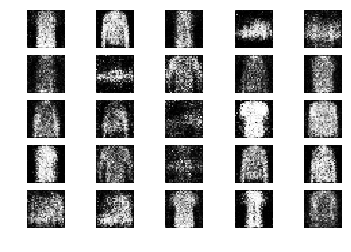

1151 [D loss: 0.649091, acc.: 0.00%] [G loss: 0.781820]
1152 [D loss: 0.625237, acc.: 0.00%] [G loss: 0.750824]
1153 [D loss: 0.636963, acc.: 0.00%] [G loss: 0.751911]
1154 [D loss: 0.616796, acc.: 0.00%] [G loss: 0.715757]
1155 [D loss: 0.692664, acc.: 0.00%] [G loss: 0.751747]
1156 [D loss: 0.630970, acc.: 0.00%] [G loss: 0.758660]
1157 [D loss: 0.605329, acc.: 0.00%] [G loss: 0.775808]
1158 [D loss: 0.645422, acc.: 0.00%] [G loss: 0.766835]
1159 [D loss: 0.670507, acc.: 0.00%] [G loss: 0.793256]
1160 [D loss: 0.666122, acc.: 0.00%] [G loss: 0.745866]
1161 [D loss: 0.620522, acc.: 0.00%] [G loss: 0.769720]
1162 [D loss: 0.667949, acc.: 0.00%] [G loss: 0.757178]
1163 [D loss: 0.641673, acc.: 0.00%] [G loss: 0.740591]
1164 [D loss: 0.679219, acc.: 0.00%] [G loss: 0.708023]
1165 [D loss: 0.663933, acc.: 0.00%] [G loss: 0.733319]
1166 [D loss: 0.654727, acc.: 0.00%] [G loss: 0.777158]
1167 [D loss: 0.658570, acc.: 0.00%] [G loss: 0.767893]
1168 [D loss: 0.663755, acc.: 0.00%] [G loss: 0.

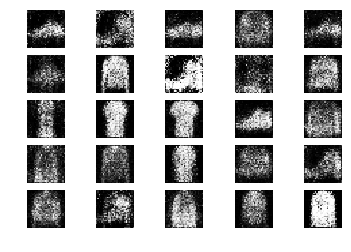

1201 [D loss: 0.661521, acc.: 0.00%] [G loss: 0.736492]
1202 [D loss: 0.594384, acc.: 0.00%] [G loss: 0.744162]
1203 [D loss: 0.677578, acc.: 0.00%] [G loss: 0.713025]
1204 [D loss: 0.644354, acc.: 0.00%] [G loss: 0.776372]
1205 [D loss: 0.681645, acc.: 0.00%] [G loss: 0.767265]
1206 [D loss: 0.672886, acc.: 0.00%] [G loss: 0.781628]
1207 [D loss: 0.661598, acc.: 0.00%] [G loss: 0.743948]
1208 [D loss: 0.630749, acc.: 0.00%] [G loss: 0.748191]
1209 [D loss: 0.670034, acc.: 0.00%] [G loss: 0.804566]
1210 [D loss: 0.591761, acc.: 0.00%] [G loss: 0.704761]
1211 [D loss: 0.618053, acc.: 0.00%] [G loss: 0.763319]
1212 [D loss: 0.676931, acc.: 0.00%] [G loss: 0.763307]
1213 [D loss: 0.670375, acc.: 0.00%] [G loss: 0.746746]
1214 [D loss: 0.662018, acc.: 0.00%] [G loss: 0.787364]
1215 [D loss: 0.591645, acc.: 0.00%] [G loss: 0.753441]
1216 [D loss: 0.636377, acc.: 0.00%] [G loss: 0.803080]
1217 [D loss: 0.631106, acc.: 0.00%] [G loss: 0.738724]
1218 [D loss: 0.615587, acc.: 0.00%] [G loss: 0.

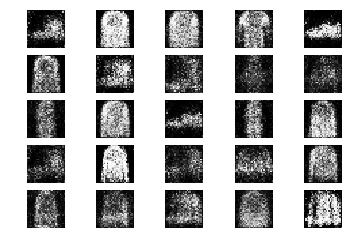

1251 [D loss: 0.624455, acc.: 0.00%] [G loss: 0.754105]
1252 [D loss: 0.663036, acc.: 0.00%] [G loss: 0.829015]
1253 [D loss: 0.647764, acc.: 0.00%] [G loss: 0.786394]
1254 [D loss: 0.675238, acc.: 0.00%] [G loss: 0.778266]
1255 [D loss: 0.657744, acc.: 0.00%] [G loss: 0.714089]
1256 [D loss: 0.618706, acc.: 0.00%] [G loss: 0.814636]
1257 [D loss: 0.660219, acc.: 0.00%] [G loss: 0.713486]
1258 [D loss: 0.657023, acc.: 0.00%] [G loss: 0.760757]
1259 [D loss: 0.680398, acc.: 0.00%] [G loss: 0.755615]
1260 [D loss: 0.645928, acc.: 0.00%] [G loss: 0.744797]
1261 [D loss: 0.645058, acc.: 0.00%] [G loss: 0.693435]
1262 [D loss: 0.593529, acc.: 0.00%] [G loss: 0.694230]
1263 [D loss: 0.698588, acc.: 0.00%] [G loss: 0.642496]
1264 [D loss: 0.630445, acc.: 0.00%] [G loss: 0.691537]
1265 [D loss: 0.651373, acc.: 0.00%] [G loss: 0.697993]
1266 [D loss: 0.669609, acc.: 0.00%] [G loss: 0.731910]
1267 [D loss: 0.636527, acc.: 0.00%] [G loss: 0.747759]
1268 [D loss: 0.622598, acc.: 0.00%] [G loss: 0.

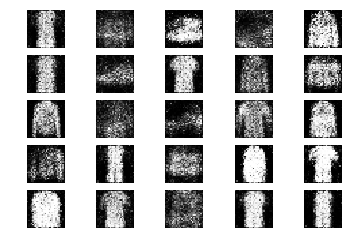

1301 [D loss: 0.693944, acc.: 0.00%] [G loss: 0.817166]
1302 [D loss: 0.631539, acc.: 0.00%] [G loss: 0.761906]
1303 [D loss: 0.667818, acc.: 0.00%] [G loss: 0.738357]
1304 [D loss: 0.598119, acc.: 0.00%] [G loss: 0.660493]
1305 [D loss: 0.622784, acc.: 0.00%] [G loss: 0.652031]
1306 [D loss: 0.627995, acc.: 0.00%] [G loss: 0.751652]
1307 [D loss: 0.620168, acc.: 0.00%] [G loss: 0.731422]
1308 [D loss: 0.618307, acc.: 0.00%] [G loss: 0.707075]
1309 [D loss: 0.666128, acc.: 0.00%] [G loss: 0.765664]
1310 [D loss: 0.606313, acc.: 0.00%] [G loss: 0.805951]
1311 [D loss: 0.701744, acc.: 0.00%] [G loss: 0.760891]
1312 [D loss: 0.614748, acc.: 0.00%] [G loss: 0.793455]
1313 [D loss: 0.622821, acc.: 0.00%] [G loss: 0.728026]
1314 [D loss: 0.632591, acc.: 0.00%] [G loss: 0.717998]
1315 [D loss: 0.645186, acc.: 0.00%] [G loss: 0.702156]
1316 [D loss: 0.663177, acc.: 0.00%] [G loss: 0.689834]
1317 [D loss: 0.687037, acc.: 0.00%] [G loss: 0.725320]
1318 [D loss: 0.662006, acc.: 0.00%] [G loss: 0.

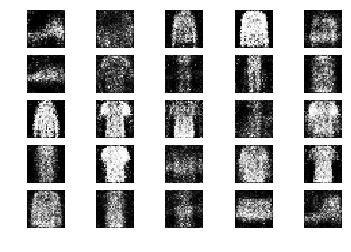

1351 [D loss: 0.603946, acc.: 0.00%] [G loss: 0.765520]
1352 [D loss: 0.659949, acc.: 0.00%] [G loss: 0.689798]
1353 [D loss: 0.625264, acc.: 0.00%] [G loss: 0.678006]
1354 [D loss: 0.598055, acc.: 0.00%] [G loss: 0.737460]
1355 [D loss: 0.682075, acc.: 0.00%] [G loss: 0.754242]
1356 [D loss: 0.623405, acc.: 0.00%] [G loss: 0.736207]
1357 [D loss: 0.657510, acc.: 0.00%] [G loss: 0.708897]
1358 [D loss: 0.675453, acc.: 0.00%] [G loss: 0.764026]
1359 [D loss: 0.619031, acc.: 0.00%] [G loss: 0.703423]
1360 [D loss: 0.669301, acc.: 0.00%] [G loss: 0.754717]
1361 [D loss: 0.626120, acc.: 0.00%] [G loss: 0.738906]
1362 [D loss: 0.621515, acc.: 0.00%] [G loss: 0.810916]
1363 [D loss: 0.645253, acc.: 0.00%] [G loss: 0.743407]
1364 [D loss: 0.634857, acc.: 0.00%] [G loss: 0.742496]
1365 [D loss: 0.624083, acc.: 0.00%] [G loss: 0.720697]
1366 [D loss: 0.684372, acc.: 0.00%] [G loss: 0.765672]
1367 [D loss: 0.654860, acc.: 0.00%] [G loss: 0.758479]
1368 [D loss: 0.635164, acc.: 0.00%] [G loss: 0.

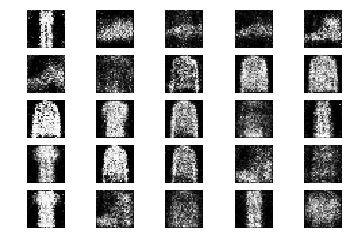

1401 [D loss: 0.642422, acc.: 0.00%] [G loss: 0.785408]
1402 [D loss: 0.642873, acc.: 0.00%] [G loss: 0.746422]
1403 [D loss: 0.653732, acc.: 0.00%] [G loss: 0.691294]
1404 [D loss: 0.642585, acc.: 0.00%] [G loss: 0.727897]
1405 [D loss: 0.644368, acc.: 0.00%] [G loss: 0.776087]
1406 [D loss: 0.588326, acc.: 0.00%] [G loss: 0.805746]
1407 [D loss: 0.660798, acc.: 0.00%] [G loss: 0.712313]
1408 [D loss: 0.639981, acc.: 0.00%] [G loss: 0.772092]
1409 [D loss: 0.630758, acc.: 0.00%] [G loss: 0.807152]
1410 [D loss: 0.649359, acc.: 0.00%] [G loss: 0.752919]
1411 [D loss: 0.624498, acc.: 0.00%] [G loss: 0.774229]
1412 [D loss: 0.639304, acc.: 0.00%] [G loss: 0.731628]
1413 [D loss: 0.685586, acc.: 0.00%] [G loss: 0.781468]
1414 [D loss: 0.633359, acc.: 0.00%] [G loss: 0.799731]
1415 [D loss: 0.664778, acc.: 0.00%] [G loss: 0.761049]
1416 [D loss: 0.642556, acc.: 0.00%] [G loss: 0.729455]
1417 [D loss: 0.632796, acc.: 0.00%] [G loss: 0.696079]
1418 [D loss: 0.636162, acc.: 0.00%] [G loss: 0.

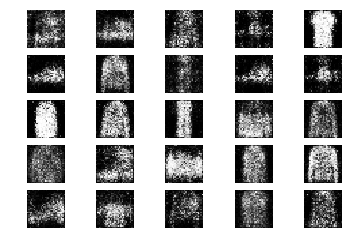

1451 [D loss: 0.648991, acc.: 0.00%] [G loss: 0.780638]
1452 [D loss: 0.646789, acc.: 0.00%] [G loss: 0.680496]
1453 [D loss: 0.624575, acc.: 0.00%] [G loss: 0.780850]
1454 [D loss: 0.653634, acc.: 0.00%] [G loss: 0.725677]
1455 [D loss: 0.671992, acc.: 0.00%] [G loss: 0.745527]
1456 [D loss: 0.594494, acc.: 0.00%] [G loss: 0.799473]
1457 [D loss: 0.589348, acc.: 0.00%] [G loss: 0.743436]
1458 [D loss: 0.648769, acc.: 0.00%] [G loss: 0.799583]
1459 [D loss: 0.595026, acc.: 0.00%] [G loss: 0.785452]
1460 [D loss: 0.625071, acc.: 0.00%] [G loss: 0.723949]
1461 [D loss: 0.612245, acc.: 0.00%] [G loss: 0.804050]
1462 [D loss: 0.643182, acc.: 0.00%] [G loss: 0.759626]
1463 [D loss: 0.622748, acc.: 0.00%] [G loss: 0.724349]
1464 [D loss: 0.657317, acc.: 0.00%] [G loss: 0.720936]
1465 [D loss: 0.656806, acc.: 0.00%] [G loss: 0.781340]
1466 [D loss: 0.624181, acc.: 0.00%] [G loss: 0.900088]
1467 [D loss: 0.617155, acc.: 0.00%] [G loss: 0.765152]
1468 [D loss: 0.639891, acc.: 0.00%] [G loss: 0.

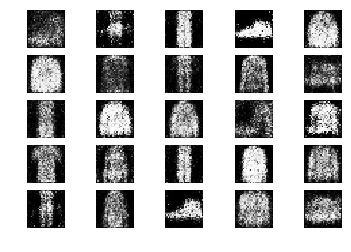

1501 [D loss: 0.634710, acc.: 0.00%] [G loss: 0.748713]
1502 [D loss: 0.643827, acc.: 0.00%] [G loss: 0.781342]
1503 [D loss: 0.667512, acc.: 0.00%] [G loss: 0.766680]
1504 [D loss: 0.647115, acc.: 0.00%] [G loss: 0.689354]
1505 [D loss: 0.628261, acc.: 0.00%] [G loss: 0.766034]
1506 [D loss: 0.622517, acc.: 0.00%] [G loss: 0.709092]
1507 [D loss: 0.625879, acc.: 0.00%] [G loss: 0.750111]
1508 [D loss: 0.652762, acc.: 0.00%] [G loss: 0.758646]
1509 [D loss: 0.698220, acc.: 0.00%] [G loss: 0.720433]
1510 [D loss: 0.632903, acc.: 0.00%] [G loss: 0.822873]
1511 [D loss: 0.637711, acc.: 0.00%] [G loss: 0.783096]
1512 [D loss: 0.665566, acc.: 0.00%] [G loss: 0.755533]
1513 [D loss: 0.640803, acc.: 0.00%] [G loss: 0.781670]
1514 [D loss: 0.637445, acc.: 0.00%] [G loss: 0.840717]
1515 [D loss: 0.679346, acc.: 0.00%] [G loss: 0.772297]
1516 [D loss: 0.629486, acc.: 0.00%] [G loss: 0.758756]
1517 [D loss: 0.632664, acc.: 0.00%] [G loss: 0.688571]
1518 [D loss: 0.618104, acc.: 0.00%] [G loss: 0.

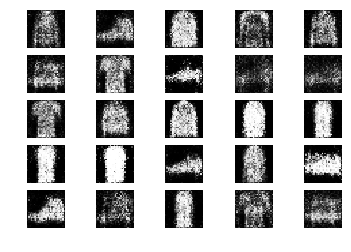

1551 [D loss: 0.618490, acc.: 0.00%] [G loss: 0.754063]
1552 [D loss: 0.649834, acc.: 0.00%] [G loss: 0.696850]
1553 [D loss: 0.654793, acc.: 0.00%] [G loss: 0.753291]
1554 [D loss: 0.628764, acc.: 0.00%] [G loss: 0.752539]
1555 [D loss: 0.619297, acc.: 0.00%] [G loss: 0.839625]
1556 [D loss: 0.641118, acc.: 0.00%] [G loss: 0.679613]
1557 [D loss: 0.610103, acc.: 0.00%] [G loss: 0.754149]
1558 [D loss: 0.637479, acc.: 0.00%] [G loss: 0.757083]
1559 [D loss: 0.717222, acc.: 0.00%] [G loss: 0.741606]
1560 [D loss: 0.689254, acc.: 0.00%] [G loss: 0.807273]
1561 [D loss: 0.677655, acc.: 0.00%] [G loss: 0.761794]
1562 [D loss: 0.646135, acc.: 0.00%] [G loss: 0.725030]
1563 [D loss: 0.653044, acc.: 0.00%] [G loss: 0.718509]
1564 [D loss: 0.680200, acc.: 0.00%] [G loss: 0.732297]
1565 [D loss: 0.608536, acc.: 0.00%] [G loss: 0.695807]
1566 [D loss: 0.647410, acc.: 0.00%] [G loss: 0.768919]
1567 [D loss: 0.631939, acc.: 0.00%] [G loss: 0.830734]
1568 [D loss: 0.633122, acc.: 0.00%] [G loss: 0.

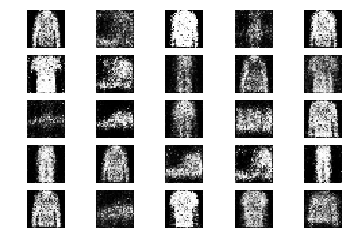

1601 [D loss: 0.672781, acc.: 0.00%] [G loss: 0.739066]
1602 [D loss: 0.615261, acc.: 0.00%] [G loss: 0.797530]
1603 [D loss: 0.628998, acc.: 0.00%] [G loss: 0.738986]
1604 [D loss: 0.654336, acc.: 0.00%] [G loss: 0.723564]
1605 [D loss: 0.661205, acc.: 0.00%] [G loss: 0.747055]
1606 [D loss: 0.655821, acc.: 0.00%] [G loss: 0.773478]
1607 [D loss: 0.619146, acc.: 0.00%] [G loss: 0.746415]
1608 [D loss: 0.629948, acc.: 0.00%] [G loss: 0.773543]
1609 [D loss: 0.642638, acc.: 0.00%] [G loss: 0.747061]
1610 [D loss: 0.616663, acc.: 0.00%] [G loss: 0.762001]
1611 [D loss: 0.628810, acc.: 0.00%] [G loss: 0.745197]
1612 [D loss: 0.630461, acc.: 0.00%] [G loss: 0.782371]
1613 [D loss: 0.652542, acc.: 0.00%] [G loss: 0.819608]
1614 [D loss: 0.672811, acc.: 0.00%] [G loss: 0.741570]
1615 [D loss: 0.645501, acc.: 0.00%] [G loss: 0.800892]
1616 [D loss: 0.646847, acc.: 0.00%] [G loss: 0.799721]
1617 [D loss: 0.608371, acc.: 0.00%] [G loss: 0.758608]
1618 [D loss: 0.642566, acc.: 0.00%] [G loss: 0.

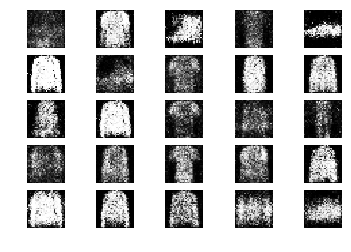

1651 [D loss: 0.644253, acc.: 0.00%] [G loss: 0.781349]
1652 [D loss: 0.650690, acc.: 0.00%] [G loss: 0.708340]
1653 [D loss: 0.594905, acc.: 0.00%] [G loss: 0.706457]
1654 [D loss: 0.604804, acc.: 0.00%] [G loss: 0.721940]
1655 [D loss: 0.621179, acc.: 0.00%] [G loss: 0.768600]
1656 [D loss: 0.660109, acc.: 0.00%] [G loss: 0.816619]
1657 [D loss: 0.639556, acc.: 0.00%] [G loss: 0.749062]
1658 [D loss: 0.702325, acc.: 0.00%] [G loss: 0.795391]
1659 [D loss: 0.639639, acc.: 0.00%] [G loss: 0.758463]
1660 [D loss: 0.661879, acc.: 0.00%] [G loss: 0.792627]
1661 [D loss: 0.629281, acc.: 0.00%] [G loss: 0.782611]
1662 [D loss: 0.640294, acc.: 0.00%] [G loss: 0.772414]
1663 [D loss: 0.641497, acc.: 0.00%] [G loss: 0.843114]
1664 [D loss: 0.595172, acc.: 0.00%] [G loss: 0.851707]
1665 [D loss: 0.645764, acc.: 0.00%] [G loss: 0.815121]
1666 [D loss: 0.670197, acc.: 0.00%] [G loss: 0.787090]
1667 [D loss: 0.659648, acc.: 0.00%] [G loss: 0.722864]
1668 [D loss: 0.628274, acc.: 0.00%] [G loss: 0.

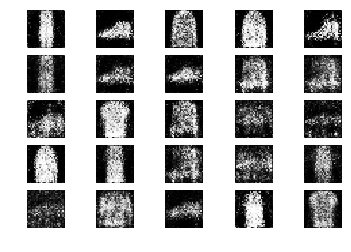

1701 [D loss: 0.655733, acc.: 0.00%] [G loss: 0.749164]
1702 [D loss: 0.651208, acc.: 0.00%] [G loss: 0.789529]
1703 [D loss: 0.684083, acc.: 0.00%] [G loss: 0.758777]
1704 [D loss: 0.665600, acc.: 0.00%] [G loss: 0.803217]
1705 [D loss: 0.601868, acc.: 0.00%] [G loss: 0.744592]
1706 [D loss: 0.690560, acc.: 0.00%] [G loss: 0.720213]
1707 [D loss: 0.648484, acc.: 0.00%] [G loss: 0.709590]
1708 [D loss: 0.660991, acc.: 0.00%] [G loss: 0.781412]
1709 [D loss: 0.638507, acc.: 0.00%] [G loss: 0.719170]
1710 [D loss: 0.595533, acc.: 0.00%] [G loss: 0.715949]
1711 [D loss: 0.642316, acc.: 0.00%] [G loss: 0.765920]
1712 [D loss: 0.667041, acc.: 0.00%] [G loss: 0.804965]
1713 [D loss: 0.606137, acc.: 0.00%] [G loss: 0.831383]
1714 [D loss: 0.645332, acc.: 0.00%] [G loss: 0.717992]
1715 [D loss: 0.621267, acc.: 0.00%] [G loss: 0.791339]
1716 [D loss: 0.668391, acc.: 0.00%] [G loss: 0.785293]
1717 [D loss: 0.644674, acc.: 0.00%] [G loss: 0.805295]
1718 [D loss: 0.579882, acc.: 0.00%] [G loss: 0.

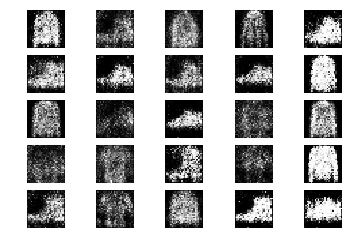

1751 [D loss: 0.631982, acc.: 0.00%] [G loss: 0.809888]
1752 [D loss: 0.617592, acc.: 0.00%] [G loss: 0.813791]
1753 [D loss: 0.665843, acc.: 0.00%] [G loss: 0.722469]
1754 [D loss: 0.671277, acc.: 0.00%] [G loss: 0.803083]
1755 [D loss: 0.621915, acc.: 0.00%] [G loss: 0.762339]
1756 [D loss: 0.651757, acc.: 0.00%] [G loss: 0.669053]
1757 [D loss: 0.621917, acc.: 0.00%] [G loss: 0.753896]
1758 [D loss: 0.671274, acc.: 0.00%] [G loss: 0.721121]
1759 [D loss: 0.594905, acc.: 0.00%] [G loss: 0.806999]
1760 [D loss: 0.628938, acc.: 0.00%] [G loss: 0.832289]
1761 [D loss: 0.675206, acc.: 0.00%] [G loss: 0.810210]
1762 [D loss: 0.639989, acc.: 0.00%] [G loss: 0.846051]
1763 [D loss: 0.602666, acc.: 0.00%] [G loss: 0.839375]
1764 [D loss: 0.727937, acc.: 0.00%] [G loss: 0.794881]
1765 [D loss: 0.658781, acc.: 0.00%] [G loss: 0.794093]
1766 [D loss: 0.624116, acc.: 0.00%] [G loss: 0.827805]
1767 [D loss: 0.638297, acc.: 0.00%] [G loss: 0.794623]
1768 [D loss: 0.614231, acc.: 0.00%] [G loss: 0.

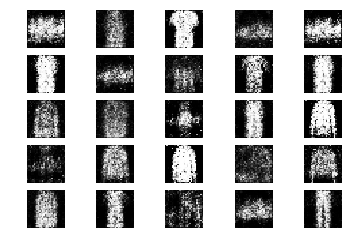

1801 [D loss: 0.665305, acc.: 0.00%] [G loss: 0.828126]
1802 [D loss: 0.613117, acc.: 0.00%] [G loss: 0.778719]
1803 [D loss: 0.620246, acc.: 0.00%] [G loss: 0.755046]
1804 [D loss: 0.652810, acc.: 0.00%] [G loss: 0.728172]
1805 [D loss: 0.601548, acc.: 0.00%] [G loss: 0.760878]
1806 [D loss: 0.678061, acc.: 0.00%] [G loss: 0.744488]
1807 [D loss: 0.542695, acc.: 0.00%] [G loss: 0.767484]
1808 [D loss: 0.703593, acc.: 0.00%] [G loss: 0.746951]
1809 [D loss: 0.634281, acc.: 0.00%] [G loss: 0.695013]
1810 [D loss: 0.656400, acc.: 0.00%] [G loss: 0.750980]
1811 [D loss: 0.674353, acc.: 0.00%] [G loss: 0.836223]
1812 [D loss: 0.624793, acc.: 0.00%] [G loss: 0.841765]
1813 [D loss: 0.621128, acc.: 0.00%] [G loss: 0.809386]
1814 [D loss: 0.667679, acc.: 0.00%] [G loss: 0.768742]
1815 [D loss: 0.636584, acc.: 0.00%] [G loss: 0.791941]
1816 [D loss: 0.604258, acc.: 0.00%] [G loss: 0.815223]
1817 [D loss: 0.584841, acc.: 0.00%] [G loss: 0.756316]
1818 [D loss: 0.620517, acc.: 0.00%] [G loss: 0.

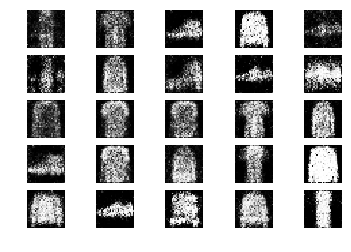

1851 [D loss: 0.608960, acc.: 0.00%] [G loss: 0.813671]
1852 [D loss: 0.648216, acc.: 0.00%] [G loss: 0.841501]
1853 [D loss: 0.648162, acc.: 0.00%] [G loss: 0.764621]
1854 [D loss: 0.640904, acc.: 0.00%] [G loss: 0.775748]
1855 [D loss: 0.628347, acc.: 0.00%] [G loss: 0.724951]
1856 [D loss: 0.608509, acc.: 0.00%] [G loss: 0.740758]
1857 [D loss: 0.635528, acc.: 0.00%] [G loss: 0.796676]
1858 [D loss: 0.645097, acc.: 0.00%] [G loss: 0.780615]
1859 [D loss: 0.639324, acc.: 0.00%] [G loss: 0.769710]
1860 [D loss: 0.650264, acc.: 0.00%] [G loss: 0.757410]
1861 [D loss: 0.660287, acc.: 0.00%] [G loss: 0.701277]
1862 [D loss: 0.625629, acc.: 0.00%] [G loss: 0.707413]
1863 [D loss: 0.633002, acc.: 0.00%] [G loss: 0.776911]
1864 [D loss: 0.611753, acc.: 0.00%] [G loss: 0.796032]
1865 [D loss: 0.650798, acc.: 0.00%] [G loss: 0.792326]
1866 [D loss: 0.654761, acc.: 0.00%] [G loss: 0.789181]
1867 [D loss: 0.609493, acc.: 0.00%] [G loss: 0.716197]
1868 [D loss: 0.640951, acc.: 0.00%] [G loss: 0.

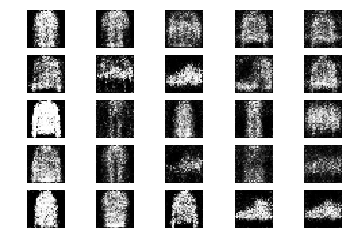

1901 [D loss: 0.661669, acc.: 0.00%] [G loss: 0.709537]
1902 [D loss: 0.631103, acc.: 0.00%] [G loss: 0.747753]
1903 [D loss: 0.625646, acc.: 0.00%] [G loss: 0.729025]
1904 [D loss: 0.641768, acc.: 0.00%] [G loss: 0.649437]
1905 [D loss: 0.635078, acc.: 0.00%] [G loss: 0.749817]
1906 [D loss: 0.631487, acc.: 0.00%] [G loss: 0.698791]
1907 [D loss: 0.656353, acc.: 0.00%] [G loss: 0.729786]
1908 [D loss: 0.610690, acc.: 0.00%] [G loss: 0.778660]
1909 [D loss: 0.582281, acc.: 0.00%] [G loss: 0.744987]
1910 [D loss: 0.576420, acc.: 0.00%] [G loss: 0.687080]
1911 [D loss: 0.675144, acc.: 0.00%] [G loss: 0.750131]
1912 [D loss: 0.634039, acc.: 0.00%] [G loss: 0.700372]
1913 [D loss: 0.637201, acc.: 0.00%] [G loss: 0.723011]
1914 [D loss: 0.671647, acc.: 0.00%] [G loss: 0.791030]
1915 [D loss: 0.617827, acc.: 0.00%] [G loss: 0.741100]
1916 [D loss: 0.665488, acc.: 0.00%] [G loss: 0.740845]
1917 [D loss: 0.664731, acc.: 0.00%] [G loss: 0.760161]
1918 [D loss: 0.615347, acc.: 0.00%] [G loss: 0.

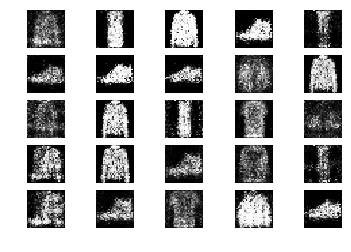

1951 [D loss: 0.645001, acc.: 0.00%] [G loss: 0.772655]
1952 [D loss: 0.577718, acc.: 0.00%] [G loss: 0.799690]
1953 [D loss: 0.616086, acc.: 0.00%] [G loss: 0.689618]
1954 [D loss: 0.678463, acc.: 0.00%] [G loss: 0.790960]
1955 [D loss: 0.640974, acc.: 0.00%] [G loss: 0.748507]
1956 [D loss: 0.609931, acc.: 0.00%] [G loss: 0.789173]
1957 [D loss: 0.630100, acc.: 0.00%] [G loss: 0.779764]
1958 [D loss: 0.611225, acc.: 0.00%] [G loss: 0.769199]
1959 [D loss: 0.696299, acc.: 0.00%] [G loss: 0.782468]
1960 [D loss: 0.620568, acc.: 0.00%] [G loss: 0.801416]
1961 [D loss: 0.648357, acc.: 0.00%] [G loss: 0.762985]
1962 [D loss: 0.649748, acc.: 0.00%] [G loss: 0.803783]
1963 [D loss: 0.658869, acc.: 0.00%] [G loss: 0.786282]
1964 [D loss: 0.711459, acc.: 0.00%] [G loss: 0.778012]
1965 [D loss: 0.644317, acc.: 0.00%] [G loss: 0.767389]
1966 [D loss: 0.644644, acc.: 0.00%] [G loss: 0.789181]
1967 [D loss: 0.662830, acc.: 0.00%] [G loss: 0.840658]
1968 [D loss: 0.623205, acc.: 0.00%] [G loss: 0.

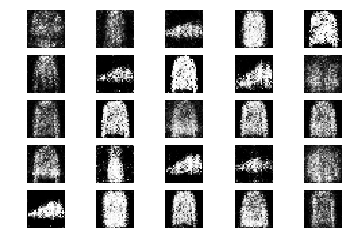

2001 [D loss: 0.628989, acc.: 0.00%] [G loss: 0.835673]
2002 [D loss: 0.624145, acc.: 0.00%] [G loss: 0.853562]
2003 [D loss: 0.678240, acc.: 0.00%] [G loss: 0.935385]
2004 [D loss: 0.632212, acc.: 0.00%] [G loss: 0.891887]
2005 [D loss: 0.619121, acc.: 0.00%] [G loss: 0.805422]
2006 [D loss: 0.636601, acc.: 0.00%] [G loss: 0.800714]
2007 [D loss: 0.594342, acc.: 0.00%] [G loss: 0.840163]
2008 [D loss: 0.655420, acc.: 0.00%] [G loss: 0.770086]
2009 [D loss: 0.671800, acc.: 0.00%] [G loss: 0.770477]
2010 [D loss: 0.624533, acc.: 0.00%] [G loss: 0.808691]
2011 [D loss: 0.599318, acc.: 0.00%] [G loss: 0.787376]
2012 [D loss: 0.598398, acc.: 0.00%] [G loss: 0.795865]
2013 [D loss: 0.687142, acc.: 0.00%] [G loss: 0.816763]
2014 [D loss: 0.585094, acc.: 0.00%] [G loss: 0.810911]
2015 [D loss: 0.641105, acc.: 0.00%] [G loss: 0.812024]
2016 [D loss: 0.614215, acc.: 0.00%] [G loss: 0.834362]
2017 [D loss: 0.634359, acc.: 0.00%] [G loss: 0.790695]
2018 [D loss: 0.667907, acc.: 0.00%] [G loss: 0.

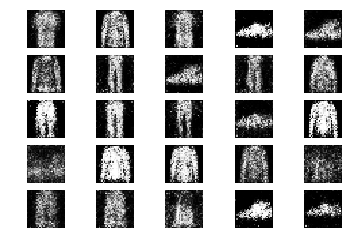

2051 [D loss: 0.672424, acc.: 0.00%] [G loss: 0.790872]
2052 [D loss: 0.579685, acc.: 0.00%] [G loss: 0.800024]
2053 [D loss: 0.657674, acc.: 0.00%] [G loss: 0.773557]
2054 [D loss: 0.576345, acc.: 0.00%] [G loss: 0.825355]
2055 [D loss: 0.603515, acc.: 0.00%] [G loss: 0.818623]
2056 [D loss: 0.614201, acc.: 0.00%] [G loss: 0.801682]
2057 [D loss: 0.669068, acc.: 0.00%] [G loss: 0.737536]
2058 [D loss: 0.697602, acc.: 0.00%] [G loss: 0.803161]
2059 [D loss: 0.624156, acc.: 0.00%] [G loss: 0.840823]
2060 [D loss: 0.651383, acc.: 0.00%] [G loss: 0.789408]
2061 [D loss: 0.608171, acc.: 0.00%] [G loss: 0.809497]
2062 [D loss: 0.596193, acc.: 0.00%] [G loss: 0.802537]
2063 [D loss: 0.572744, acc.: 0.00%] [G loss: 0.792478]
2064 [D loss: 0.684981, acc.: 0.00%] [G loss: 0.789543]
2065 [D loss: 0.653302, acc.: 0.00%] [G loss: 0.840421]
2066 [D loss: 0.648388, acc.: 0.00%] [G loss: 0.867675]
2067 [D loss: 0.617668, acc.: 0.00%] [G loss: 0.832836]
2068 [D loss: 0.638258, acc.: 0.00%] [G loss: 0.

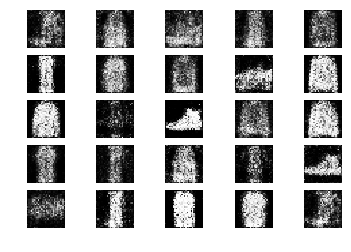

2101 [D loss: 0.642621, acc.: 0.00%] [G loss: 0.837871]
2102 [D loss: 0.678915, acc.: 0.00%] [G loss: 0.791690]
2103 [D loss: 0.676594, acc.: 0.00%] [G loss: 0.790567]
2104 [D loss: 0.631217, acc.: 0.00%] [G loss: 0.811595]
2105 [D loss: 0.683634, acc.: 0.00%] [G loss: 0.815697]
2106 [D loss: 0.599084, acc.: 0.00%] [G loss: 0.818812]
2107 [D loss: 0.699529, acc.: 0.00%] [G loss: 0.724042]
2108 [D loss: 0.630845, acc.: 0.00%] [G loss: 0.784301]
2109 [D loss: 0.615967, acc.: 0.00%] [G loss: 0.800299]
2110 [D loss: 0.607384, acc.: 0.00%] [G loss: 0.811682]
2111 [D loss: 0.586333, acc.: 0.00%] [G loss: 0.769522]
2112 [D loss: 0.704788, acc.: 0.00%] [G loss: 0.757821]
2113 [D loss: 0.696142, acc.: 0.00%] [G loss: 0.769092]
2114 [D loss: 0.646206, acc.: 0.00%] [G loss: 0.833990]
2115 [D loss: 0.618985, acc.: 0.00%] [G loss: 0.777621]
2116 [D loss: 0.651237, acc.: 0.00%] [G loss: 0.751799]
2117 [D loss: 0.635869, acc.: 0.00%] [G loss: 0.755730]
2118 [D loss: 0.667433, acc.: 0.00%] [G loss: 0.

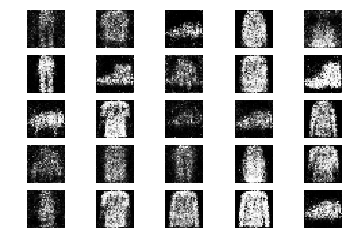

2151 [D loss: 0.634490, acc.: 0.00%] [G loss: 0.784236]
2152 [D loss: 0.623430, acc.: 0.00%] [G loss: 0.712624]
2153 [D loss: 0.610053, acc.: 0.00%] [G loss: 0.780570]
2154 [D loss: 0.647605, acc.: 0.00%] [G loss: 0.777857]
2155 [D loss: 0.562828, acc.: 0.00%] [G loss: 0.779452]
2156 [D loss: 0.693550, acc.: 0.00%] [G loss: 0.708576]
2157 [D loss: 0.660728, acc.: 0.00%] [G loss: 0.771893]
2158 [D loss: 0.608347, acc.: 0.00%] [G loss: 0.788746]
2159 [D loss: 0.637461, acc.: 0.00%] [G loss: 0.789833]
2160 [D loss: 0.659478, acc.: 0.00%] [G loss: 0.765775]
2161 [D loss: 0.691803, acc.: 0.00%] [G loss: 0.794118]
2162 [D loss: 0.652319, acc.: 0.00%] [G loss: 0.770002]
2163 [D loss: 0.633903, acc.: 0.00%] [G loss: 0.800765]
2164 [D loss: 0.632226, acc.: 0.00%] [G loss: 0.739597]
2165 [D loss: 0.658450, acc.: 0.00%] [G loss: 0.804984]
2166 [D loss: 0.674323, acc.: 0.00%] [G loss: 0.736866]
2167 [D loss: 0.588989, acc.: 0.00%] [G loss: 0.755050]
2168 [D loss: 0.643529, acc.: 0.00%] [G loss: 0.

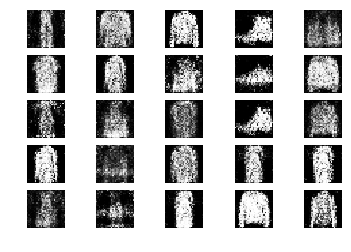

2201 [D loss: 0.629361, acc.: 0.00%] [G loss: 0.766432]
2202 [D loss: 0.616402, acc.: 0.00%] [G loss: 0.804779]
2203 [D loss: 0.597010, acc.: 0.00%] [G loss: 0.844835]
2204 [D loss: 0.650460, acc.: 0.00%] [G loss: 0.750689]
2205 [D loss: 0.682563, acc.: 0.00%] [G loss: 0.769035]
2206 [D loss: 0.695149, acc.: 0.00%] [G loss: 0.792878]
2207 [D loss: 0.614830, acc.: 0.00%] [G loss: 0.790595]
2208 [D loss: 0.649334, acc.: 0.00%] [G loss: 0.766675]
2209 [D loss: 0.650064, acc.: 0.00%] [G loss: 0.811816]
2210 [D loss: 0.613699, acc.: 0.00%] [G loss: 0.797886]
2211 [D loss: 0.654933, acc.: 0.00%] [G loss: 0.802253]
2212 [D loss: 0.614184, acc.: 0.00%] [G loss: 0.834263]
2213 [D loss: 0.595463, acc.: 0.00%] [G loss: 0.763525]
2214 [D loss: 0.653520, acc.: 0.00%] [G loss: 0.753368]
2215 [D loss: 0.569526, acc.: 0.00%] [G loss: 0.768827]
2216 [D loss: 0.670196, acc.: 0.00%] [G loss: 0.809152]
2217 [D loss: 0.637911, acc.: 0.00%] [G loss: 0.706293]
2218 [D loss: 0.618468, acc.: 0.00%] [G loss: 0.

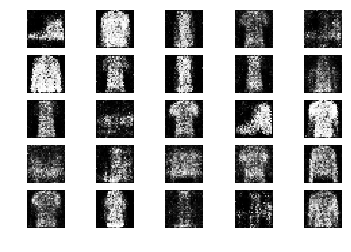

2251 [D loss: 0.684017, acc.: 0.00%] [G loss: 0.763613]
2252 [D loss: 0.651184, acc.: 0.00%] [G loss: 0.808498]
2253 [D loss: 0.598618, acc.: 0.00%] [G loss: 0.732525]
2254 [D loss: 0.591787, acc.: 0.00%] [G loss: 0.767030]
2255 [D loss: 0.641977, acc.: 0.00%] [G loss: 0.745485]
2256 [D loss: 0.677175, acc.: 0.00%] [G loss: 0.784108]
2257 [D loss: 0.624700, acc.: 0.00%] [G loss: 0.804447]
2258 [D loss: 0.624772, acc.: 0.00%] [G loss: 0.773681]
2259 [D loss: 0.660897, acc.: 0.00%] [G loss: 0.809612]
2260 [D loss: 0.645667, acc.: 0.00%] [G loss: 0.815925]
2261 [D loss: 0.614926, acc.: 0.00%] [G loss: 0.744617]
2262 [D loss: 0.613305, acc.: 0.00%] [G loss: 0.772362]
2263 [D loss: 0.638671, acc.: 0.00%] [G loss: 0.790107]
2264 [D loss: 0.629946, acc.: 0.00%] [G loss: 0.681048]
2265 [D loss: 0.658469, acc.: 0.00%] [G loss: 0.746394]
2266 [D loss: 0.657039, acc.: 0.00%] [G loss: 0.779906]
2267 [D loss: 0.652761, acc.: 0.00%] [G loss: 0.801019]
2268 [D loss: 0.652902, acc.: 0.00%] [G loss: 0.

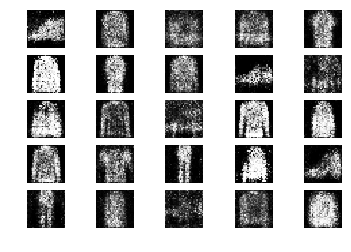

2301 [D loss: 0.633097, acc.: 0.00%] [G loss: 0.797032]
2302 [D loss: 0.636979, acc.: 0.00%] [G loss: 0.810060]
2303 [D loss: 0.562337, acc.: 0.00%] [G loss: 0.808240]
2304 [D loss: 0.624852, acc.: 0.00%] [G loss: 0.814342]
2305 [D loss: 0.628470, acc.: 0.00%] [G loss: 0.795681]
2306 [D loss: 0.649426, acc.: 0.00%] [G loss: 0.732283]
2307 [D loss: 0.617461, acc.: 0.00%] [G loss: 0.751331]
2308 [D loss: 0.662792, acc.: 0.00%] [G loss: 0.770237]
2309 [D loss: 0.660532, acc.: 0.00%] [G loss: 0.797871]
2310 [D loss: 0.640909, acc.: 0.00%] [G loss: 0.834127]
2311 [D loss: 0.602040, acc.: 0.00%] [G loss: 0.835242]
2312 [D loss: 0.655539, acc.: 0.00%] [G loss: 0.840187]
2313 [D loss: 0.679035, acc.: 0.00%] [G loss: 0.797417]
2314 [D loss: 0.645648, acc.: 0.00%] [G loss: 0.820598]
2315 [D loss: 0.673422, acc.: 0.00%] [G loss: 0.819869]
2316 [D loss: 0.661566, acc.: 0.00%] [G loss: 0.711416]
2317 [D loss: 0.654309, acc.: 0.00%] [G loss: 0.782329]
2318 [D loss: 0.633770, acc.: 0.00%] [G loss: 0.

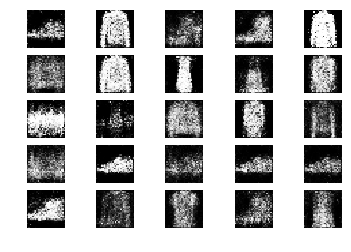

2351 [D loss: 0.653064, acc.: 0.00%] [G loss: 0.738694]
2352 [D loss: 0.664299, acc.: 0.00%] [G loss: 0.770144]
2353 [D loss: 0.621013, acc.: 0.00%] [G loss: 0.770603]
2354 [D loss: 0.596445, acc.: 0.00%] [G loss: 0.805154]
2355 [D loss: 0.616079, acc.: 0.00%] [G loss: 0.834032]
2356 [D loss: 0.661583, acc.: 0.00%] [G loss: 0.821336]
2357 [D loss: 0.626588, acc.: 0.00%] [G loss: 0.798764]
2358 [D loss: 0.693803, acc.: 0.00%] [G loss: 0.812567]
2359 [D loss: 0.665972, acc.: 0.00%] [G loss: 0.803432]
2360 [D loss: 0.656971, acc.: 0.00%] [G loss: 0.761772]
2361 [D loss: 0.684066, acc.: 0.00%] [G loss: 0.777516]
2362 [D loss: 0.622564, acc.: 0.00%] [G loss: 0.782568]
2363 [D loss: 0.618286, acc.: 0.00%] [G loss: 0.746020]
2364 [D loss: 0.617988, acc.: 0.00%] [G loss: 0.762835]
2365 [D loss: 0.714195, acc.: 0.00%] [G loss: 0.760222]
2366 [D loss: 0.614065, acc.: 0.00%] [G loss: 0.809905]
2367 [D loss: 0.618917, acc.: 0.00%] [G loss: 0.779724]
2368 [D loss: 0.600351, acc.: 0.00%] [G loss: 0.

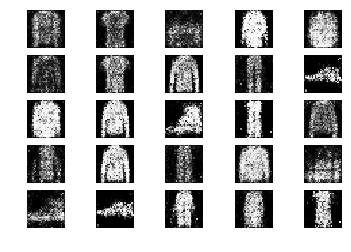

2401 [D loss: 0.623220, acc.: 0.00%] [G loss: 0.784996]
2402 [D loss: 0.645608, acc.: 0.00%] [G loss: 0.784017]
2403 [D loss: 0.549930, acc.: 0.00%] [G loss: 0.762773]
2404 [D loss: 0.646554, acc.: 0.00%] [G loss: 0.763801]
2405 [D loss: 0.636392, acc.: 0.00%] [G loss: 0.767201]
2406 [D loss: 0.603098, acc.: 0.00%] [G loss: 0.779596]
2407 [D loss: 0.613777, acc.: 0.00%] [G loss: 0.763451]
2408 [D loss: 0.669121, acc.: 0.00%] [G loss: 0.803990]
2409 [D loss: 0.648006, acc.: 0.00%] [G loss: 0.732688]
2410 [D loss: 0.597489, acc.: 0.00%] [G loss: 0.820044]
2411 [D loss: 0.574846, acc.: 0.00%] [G loss: 0.766244]
2412 [D loss: 0.744017, acc.: 0.00%] [G loss: 0.721204]
2413 [D loss: 0.651034, acc.: 0.00%] [G loss: 0.717640]
2414 [D loss: 0.637222, acc.: 0.00%] [G loss: 0.780272]
2415 [D loss: 0.640155, acc.: 0.00%] [G loss: 0.871158]
2416 [D loss: 0.635363, acc.: 0.00%] [G loss: 0.708279]
2417 [D loss: 0.641084, acc.: 0.00%] [G loss: 0.803909]
2418 [D loss: 0.652566, acc.: 0.00%] [G loss: 0.

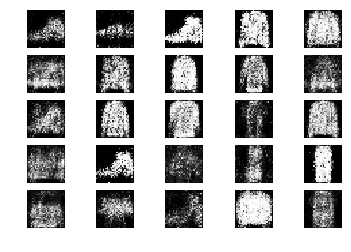

2451 [D loss: 0.633486, acc.: 0.00%] [G loss: 0.739452]
2452 [D loss: 0.620757, acc.: 0.00%] [G loss: 0.822895]
2453 [D loss: 0.656692, acc.: 0.00%] [G loss: 0.752188]
2454 [D loss: 0.652516, acc.: 0.00%] [G loss: 0.770913]
2455 [D loss: 0.685970, acc.: 0.00%] [G loss: 0.711737]
2456 [D loss: 0.625737, acc.: 0.00%] [G loss: 0.790322]
2457 [D loss: 0.641555, acc.: 0.00%] [G loss: 0.851765]
2458 [D loss: 0.588279, acc.: 0.00%] [G loss: 0.779755]
2459 [D loss: 0.639165, acc.: 0.00%] [G loss: 0.781259]
2460 [D loss: 0.668999, acc.: 0.00%] [G loss: 0.748644]
2461 [D loss: 0.632435, acc.: 0.00%] [G loss: 0.757605]
2462 [D loss: 0.609743, acc.: 0.00%] [G loss: 0.816009]
2463 [D loss: 0.633926, acc.: 0.00%] [G loss: 0.799642]
2464 [D loss: 0.647513, acc.: 0.00%] [G loss: 0.775102]
2465 [D loss: 0.680948, acc.: 0.00%] [G loss: 0.784125]
2466 [D loss: 0.669291, acc.: 0.00%] [G loss: 0.795115]
2467 [D loss: 0.619494, acc.: 0.00%] [G loss: 0.743820]
2468 [D loss: 0.679928, acc.: 0.00%] [G loss: 0.

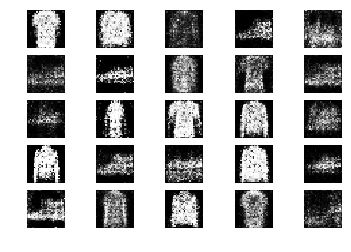

2501 [D loss: 0.639589, acc.: 0.00%] [G loss: 0.855922]
2502 [D loss: 0.642187, acc.: 0.00%] [G loss: 0.784571]
2503 [D loss: 0.695604, acc.: 0.00%] [G loss: 0.822530]
2504 [D loss: 0.664004, acc.: 0.00%] [G loss: 0.838343]
2505 [D loss: 0.660468, acc.: 0.00%] [G loss: 0.836035]
2506 [D loss: 0.604868, acc.: 0.00%] [G loss: 0.750843]
2507 [D loss: 0.635738, acc.: 0.00%] [G loss: 0.801900]
2508 [D loss: 0.660121, acc.: 0.00%] [G loss: 0.845372]
2509 [D loss: 0.608445, acc.: 0.00%] [G loss: 0.730871]
2510 [D loss: 0.629375, acc.: 0.00%] [G loss: 0.742867]
2511 [D loss: 0.609614, acc.: 0.00%] [G loss: 0.820190]
2512 [D loss: 0.638668, acc.: 0.00%] [G loss: 0.774986]
2513 [D loss: 0.634647, acc.: 0.00%] [G loss: 0.756396]
2514 [D loss: 0.597450, acc.: 0.00%] [G loss: 0.754938]
2515 [D loss: 0.609635, acc.: 0.00%] [G loss: 0.839908]
2516 [D loss: 0.627242, acc.: 0.00%] [G loss: 0.881095]
2517 [D loss: 0.640393, acc.: 0.00%] [G loss: 0.763415]
2518 [D loss: 0.627784, acc.: 0.00%] [G loss: 0.

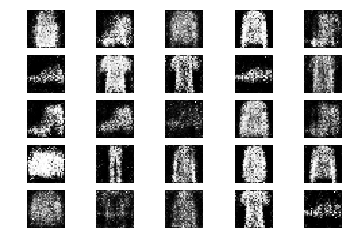

2551 [D loss: 0.659456, acc.: 0.00%] [G loss: 0.821742]
2552 [D loss: 0.637104, acc.: 0.00%] [G loss: 0.765036]
2553 [D loss: 0.588133, acc.: 0.00%] [G loss: 0.826570]
2554 [D loss: 0.607741, acc.: 0.00%] [G loss: 0.825569]
2555 [D loss: 0.689299, acc.: 0.00%] [G loss: 0.818885]
2556 [D loss: 0.672152, acc.: 0.00%] [G loss: 0.756064]
2557 [D loss: 0.606457, acc.: 0.00%] [G loss: 0.815499]
2558 [D loss: 0.660945, acc.: 0.00%] [G loss: 0.758597]
2559 [D loss: 0.626797, acc.: 0.00%] [G loss: 0.787574]
2560 [D loss: 0.669959, acc.: 0.00%] [G loss: 0.756247]
2561 [D loss: 0.660984, acc.: 0.00%] [G loss: 0.769808]
2562 [D loss: 0.608681, acc.: 0.00%] [G loss: 0.792008]
2563 [D loss: 0.669537, acc.: 0.00%] [G loss: 0.762102]
2564 [D loss: 0.617095, acc.: 0.00%] [G loss: 0.788318]
2565 [D loss: 0.694156, acc.: 0.00%] [G loss: 0.698005]
2566 [D loss: 0.638273, acc.: 0.00%] [G loss: 0.739038]
2567 [D loss: 0.617083, acc.: 0.00%] [G loss: 0.736380]
2568 [D loss: 0.605869, acc.: 0.00%] [G loss: 0.

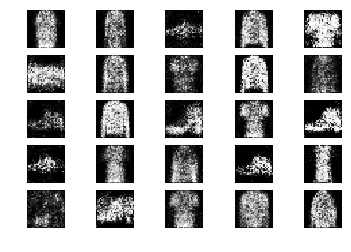

2601 [D loss: 0.576267, acc.: 0.00%] [G loss: 0.763672]
2602 [D loss: 0.667520, acc.: 0.00%] [G loss: 0.736912]
2603 [D loss: 0.624467, acc.: 0.00%] [G loss: 0.733771]
2604 [D loss: 0.641566, acc.: 0.00%] [G loss: 0.708953]
2605 [D loss: 0.634519, acc.: 0.00%] [G loss: 0.735478]
2606 [D loss: 0.644302, acc.: 0.00%] [G loss: 0.773322]
2607 [D loss: 0.644355, acc.: 0.00%] [G loss: 0.806773]
2608 [D loss: 0.622559, acc.: 0.00%] [G loss: 0.801760]
2609 [D loss: 0.691983, acc.: 0.00%] [G loss: 0.809630]
2610 [D loss: 0.664375, acc.: 0.00%] [G loss: 0.784868]
2611 [D loss: 0.665390, acc.: 0.00%] [G loss: 0.751906]
2612 [D loss: 0.681665, acc.: 0.00%] [G loss: 0.773500]
2613 [D loss: 0.605764, acc.: 0.00%] [G loss: 0.789107]
2614 [D loss: 0.630835, acc.: 0.00%] [G loss: 0.781718]
2615 [D loss: 0.648744, acc.: 0.00%] [G loss: 0.770817]
2616 [D loss: 0.604935, acc.: 0.00%] [G loss: 0.788946]
2617 [D loss: 0.646905, acc.: 0.00%] [G loss: 0.767064]
2618 [D loss: 0.658367, acc.: 0.00%] [G loss: 0.

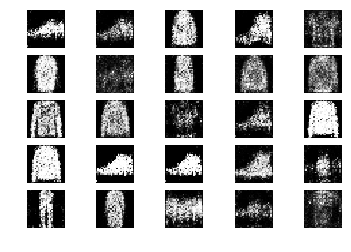

2651 [D loss: 0.640115, acc.: 0.00%] [G loss: 0.765029]
2652 [D loss: 0.635713, acc.: 0.00%] [G loss: 0.739409]
2653 [D loss: 0.561291, acc.: 0.00%] [G loss: 0.788150]
2654 [D loss: 0.643134, acc.: 0.00%] [G loss: 0.830829]
2655 [D loss: 0.616388, acc.: 0.00%] [G loss: 0.881570]
2656 [D loss: 0.697602, acc.: 0.00%] [G loss: 0.779762]
2657 [D loss: 0.630767, acc.: 0.00%] [G loss: 0.848071]
2658 [D loss: 0.674711, acc.: 0.00%] [G loss: 0.814385]
2659 [D loss: 0.696882, acc.: 0.00%] [G loss: 0.813537]
2660 [D loss: 0.657839, acc.: 0.00%] [G loss: 0.760074]
2661 [D loss: 0.622484, acc.: 0.00%] [G loss: 0.791179]
2662 [D loss: 0.653937, acc.: 0.00%] [G loss: 0.756647]
2663 [D loss: 0.614613, acc.: 0.00%] [G loss: 0.772019]
2664 [D loss: 0.607352, acc.: 0.00%] [G loss: 0.776060]
2665 [D loss: 0.657946, acc.: 0.00%] [G loss: 0.806406]
2666 [D loss: 0.617515, acc.: 0.00%] [G loss: 0.757323]
2667 [D loss: 0.687479, acc.: 0.00%] [G loss: 0.743100]
2668 [D loss: 0.626341, acc.: 0.00%] [G loss: 0.

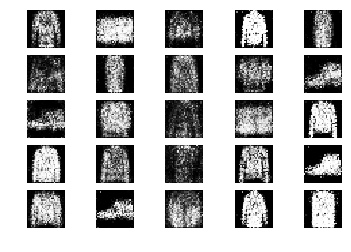

2701 [D loss: 0.616180, acc.: 0.00%] [G loss: 0.795706]
2702 [D loss: 0.609032, acc.: 0.00%] [G loss: 0.778719]
2703 [D loss: 0.606686, acc.: 0.00%] [G loss: 0.798223]
2704 [D loss: 0.635018, acc.: 0.00%] [G loss: 0.825371]
2705 [D loss: 0.662013, acc.: 0.00%] [G loss: 0.723339]
2706 [D loss: 0.621232, acc.: 0.00%] [G loss: 0.794219]
2707 [D loss: 0.671847, acc.: 0.00%] [G loss: 0.763503]
2708 [D loss: 0.669623, acc.: 0.00%] [G loss: 0.793245]
2709 [D loss: 0.679805, acc.: 0.00%] [G loss: 0.796558]
2710 [D loss: 0.646508, acc.: 0.00%] [G loss: 0.712115]
2711 [D loss: 0.602044, acc.: 0.00%] [G loss: 0.800319]
2712 [D loss: 0.647520, acc.: 0.00%] [G loss: 0.710169]
2713 [D loss: 0.630190, acc.: 0.00%] [G loss: 0.779477]
2714 [D loss: 0.621130, acc.: 0.00%] [G loss: 0.732368]
2715 [D loss: 0.614586, acc.: 0.00%] [G loss: 0.812035]
2716 [D loss: 0.581269, acc.: 0.00%] [G loss: 0.845998]
2717 [D loss: 0.648650, acc.: 0.00%] [G loss: 0.823665]
2718 [D loss: 0.663522, acc.: 0.00%] [G loss: 0.

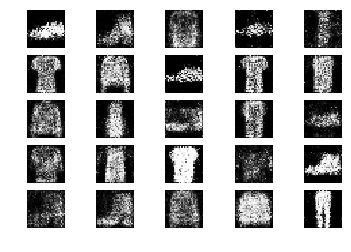

2751 [D loss: 0.607225, acc.: 0.00%] [G loss: 0.811305]
2752 [D loss: 0.691699, acc.: 0.00%] [G loss: 0.805999]
2753 [D loss: 0.673139, acc.: 0.00%] [G loss: 0.805161]
2754 [D loss: 0.662908, acc.: 0.00%] [G loss: 0.772792]
2755 [D loss: 0.630380, acc.: 0.00%] [G loss: 0.757920]
2756 [D loss: 0.666539, acc.: 0.00%] [G loss: 0.776900]
2757 [D loss: 0.672188, acc.: 0.00%] [G loss: 0.747399]
2758 [D loss: 0.679134, acc.: 0.00%] [G loss: 0.775396]
2759 [D loss: 0.667705, acc.: 0.00%] [G loss: 0.826088]
2760 [D loss: 0.618410, acc.: 0.00%] [G loss: 0.811703]
2761 [D loss: 0.674801, acc.: 0.00%] [G loss: 0.773691]
2762 [D loss: 0.645332, acc.: 0.00%] [G loss: 0.792053]
2763 [D loss: 0.629998, acc.: 0.00%] [G loss: 0.781064]
2764 [D loss: 0.622794, acc.: 0.00%] [G loss: 0.804004]
2765 [D loss: 0.666017, acc.: 0.00%] [G loss: 0.832433]
2766 [D loss: 0.617812, acc.: 0.00%] [G loss: 0.845103]
2767 [D loss: 0.625262, acc.: 0.00%] [G loss: 0.829911]
2768 [D loss: 0.626544, acc.: 0.00%] [G loss: 0.

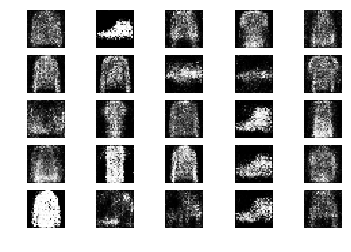

2801 [D loss: 0.652875, acc.: 0.00%] [G loss: 0.776448]
2802 [D loss: 0.685098, acc.: 0.00%] [G loss: 0.741254]
2803 [D loss: 0.673043, acc.: 0.00%] [G loss: 0.756456]
2804 [D loss: 0.655788, acc.: 0.00%] [G loss: 0.826003]
2805 [D loss: 0.625307, acc.: 0.00%] [G loss: 0.762003]
2806 [D loss: 0.586390, acc.: 0.00%] [G loss: 0.816156]
2807 [D loss: 0.669480, acc.: 0.00%] [G loss: 0.769056]
2808 [D loss: 0.656548, acc.: 0.00%] [G loss: 0.850177]
2809 [D loss: 0.610561, acc.: 0.00%] [G loss: 0.821593]
2810 [D loss: 0.686221, acc.: 0.00%] [G loss: 0.792096]
2811 [D loss: 0.576463, acc.: 0.00%] [G loss: 0.875193]
2812 [D loss: 0.608430, acc.: 0.00%] [G loss: 0.766398]
2813 [D loss: 0.665247, acc.: 0.00%] [G loss: 0.837663]
2814 [D loss: 0.675563, acc.: 0.00%] [G loss: 0.763304]
2815 [D loss: 0.591779, acc.: 0.00%] [G loss: 0.768506]
2816 [D loss: 0.670394, acc.: 0.00%] [G loss: 0.739749]
2817 [D loss: 0.664907, acc.: 0.00%] [G loss: 0.793763]
2818 [D loss: 0.600210, acc.: 0.00%] [G loss: 0.

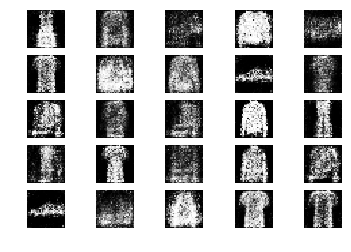

2851 [D loss: 0.657768, acc.: 0.00%] [G loss: 0.726175]
2852 [D loss: 0.642021, acc.: 0.00%] [G loss: 0.796724]
2853 [D loss: 0.596549, acc.: 0.00%] [G loss: 0.747919]
2854 [D loss: 0.656921, acc.: 0.00%] [G loss: 0.799430]
2855 [D loss: 0.673944, acc.: 0.00%] [G loss: 0.745812]
2856 [D loss: 0.650364, acc.: 0.00%] [G loss: 0.803631]
2857 [D loss: 0.638257, acc.: 0.00%] [G loss: 0.841402]
2858 [D loss: 0.666057, acc.: 0.00%] [G loss: 0.789830]
2859 [D loss: 0.638170, acc.: 0.00%] [G loss: 0.835346]
2860 [D loss: 0.593012, acc.: 0.00%] [G loss: 0.779522]
2861 [D loss: 0.644145, acc.: 0.00%] [G loss: 0.829952]
2862 [D loss: 0.645068, acc.: 0.00%] [G loss: 0.786649]
2863 [D loss: 0.614436, acc.: 0.00%] [G loss: 0.793306]
2864 [D loss: 0.642303, acc.: 0.00%] [G loss: 0.666171]
2865 [D loss: 0.630111, acc.: 0.00%] [G loss: 0.787877]
2866 [D loss: 0.661574, acc.: 0.00%] [G loss: 0.821764]
2867 [D loss: 0.665479, acc.: 0.00%] [G loss: 0.778867]
2868 [D loss: 0.596620, acc.: 0.00%] [G loss: 0.

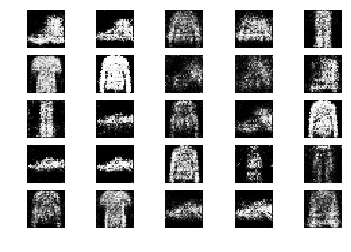

2901 [D loss: 0.623322, acc.: 0.00%] [G loss: 0.799524]
2902 [D loss: 0.703939, acc.: 0.00%] [G loss: 0.761014]
2903 [D loss: 0.669940, acc.: 0.00%] [G loss: 0.849483]
2904 [D loss: 0.618670, acc.: 0.00%] [G loss: 0.788228]
2905 [D loss: 0.599167, acc.: 0.00%] [G loss: 0.767818]
2906 [D loss: 0.652981, acc.: 0.00%] [G loss: 0.826526]
2907 [D loss: 0.676698, acc.: 0.00%] [G loss: 0.777109]
2908 [D loss: 0.645776, acc.: 0.00%] [G loss: 0.765480]
2909 [D loss: 0.647588, acc.: 0.00%] [G loss: 0.854806]
2910 [D loss: 0.622322, acc.: 0.00%] [G loss: 0.881568]
2911 [D loss: 0.596504, acc.: 0.00%] [G loss: 0.841440]
2912 [D loss: 0.641593, acc.: 0.00%] [G loss: 0.832096]
2913 [D loss: 0.605939, acc.: 0.00%] [G loss: 0.833896]
2914 [D loss: 0.668669, acc.: 0.00%] [G loss: 0.826723]
2915 [D loss: 0.602101, acc.: 0.00%] [G loss: 0.811560]
2916 [D loss: 0.654568, acc.: 0.00%] [G loss: 0.744511]
2917 [D loss: 0.632085, acc.: 0.00%] [G loss: 0.772337]
2918 [D loss: 0.610031, acc.: 0.00%] [G loss: 0.

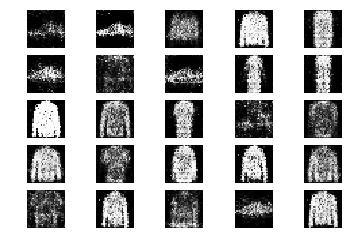

2951 [D loss: 0.647807, acc.: 0.00%] [G loss: 0.776121]
2952 [D loss: 0.601398, acc.: 0.00%] [G loss: 0.762955]
2953 [D loss: 0.670049, acc.: 0.00%] [G loss: 0.742804]
2954 [D loss: 0.659140, acc.: 0.00%] [G loss: 0.823956]
2955 [D loss: 0.656602, acc.: 0.00%] [G loss: 0.838701]
2956 [D loss: 0.626472, acc.: 0.00%] [G loss: 0.817353]
2957 [D loss: 0.668284, acc.: 0.00%] [G loss: 0.768401]
2958 [D loss: 0.666586, acc.: 0.00%] [G loss: 0.734346]
2959 [D loss: 0.642307, acc.: 0.00%] [G loss: 0.881571]
2960 [D loss: 0.635598, acc.: 0.00%] [G loss: 0.760851]
2961 [D loss: 0.617708, acc.: 0.00%] [G loss: 0.760463]
2962 [D loss: 0.624470, acc.: 0.00%] [G loss: 0.784974]
2963 [D loss: 0.591857, acc.: 0.00%] [G loss: 0.709016]
2964 [D loss: 0.670819, acc.: 0.00%] [G loss: 0.725735]
2965 [D loss: 0.642980, acc.: 0.00%] [G loss: 0.818687]
2966 [D loss: 0.630936, acc.: 0.00%] [G loss: 0.829169]
2967 [D loss: 0.666452, acc.: 0.00%] [G loss: 0.793779]
2968 [D loss: 0.627566, acc.: 0.00%] [G loss: 0.

In [15]:
epochs = 3000

batch_size = 32


for epoch in range(epochs):
  # smooth the labels
  valid = np.random.uniform(0.7, 1.2, (batch_size, 1))
  fake = np.random.uniform(0.0, 0.3, (batch_size, 1))
  # Train discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size) #randomly grab batch size many training images
  imgs = x_train[idx]

  noise = np.random.normal(0, 1, (batch_size, 100)) # create 32x100 N(0,1) noises

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid) # runs a single gradient update per batch; first: look at real images and train on those
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # here: look at fake images and train on those
  d_loss = 0.5*np.add(d_loss_real, d_loss_fake) # above 2 lines give scalar loss (accuracy for us); our loss is the average of the two

  # Train generator
  noise = np.random.normal(0, 1, (batch_size, 100)) # why new noise? probably doesnt matter, bc of iid
  
  # combined takes noise and returns validity; our target is that valididty should be as close to
  # valid (==1) as possible
  g_loss = combined.train_on_batch(noise, valid) 

  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

  if epoch % 50 == 0:
    sample_images(epoch)

## Check how the generator is doing

This looks quite neat!

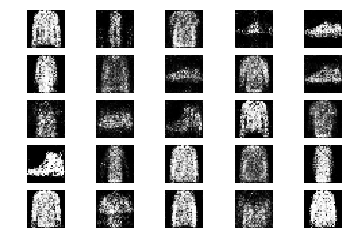

In [27]:
sample_images(1)

## Save and re-load the model!

Check, that it indeed saved correctly!

In [0]:
generator.save('generator.h5')

In [0]:
discriminator.save('discriminator.h5')
combined.save('combined.h5')

In [30]:
from keras.models import load_model

generator_loaded = load_model('generator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def sample_images_loaded(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator_loaded.predict(noise) # the .predict() method is essentially a "run this model with input noise"

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

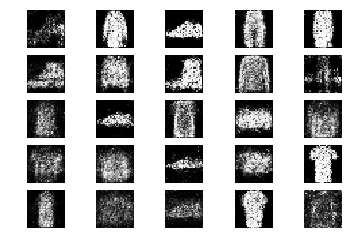

In [32]:
sample_images_loaded(1)